## ***ImportFinancialData***

In this notebook we will develop the following steps:
- Extraction of financial and business data using custom filtering
- Short check and cleaning of potential duplicates not detected during pre-processing
- Data analysis that seeks at the same time, through integration features, to maximize and facilitate the understanding of data (highly manageable and customizable approach)
- Specific analysis of outliers using the IsolatioForest machine learning model
- Imputation of data through texts of multiple machine learning models and use for definitive imputation of the model with the best performance

To give more detail of how the extraction phase (first step) takes place:
1. scrape sectors company available from Barron's website
1. scrape financial data from MarketWatch website
2. select specific sector you're interested in
2. get *financial* table (with target currency specified)
3. get corporate table (income, balance sheet, cash flow, ratio table) (with target currency specified)

<u>*Note*</u>: about **ratio table** it is custom and indices will have objective to indentify main characteristics that show how corporate is going viewing itself and comparing with others*

## ScrapedFinancialData

**<u>SetUp</u>**

In [3]:
#IMPORTANT: to know time spending
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2023-09-11 19:50:58 +02:00)


In [1]:
# pip install --upgrade pandas pyarrow

In [662]:
# pip install klib

time: 0 ns (started: 2023-08-31 17:04:46 +02:00)


In [5]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from io import StringIO
import time
import numpy as np
import threading
import klib # custom library (pip install klib) # EDA analysis

time: 7.08 s (started: 2023-09-11 19:51:02 +02:00)


In [6]:
# Make sure pandas version is over or same of 2.1.0 
print(pd.__version__)

2.1.0
time: 0 ns (started: 2023-09-11 19:51:09 +02:00)


In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

time: 485 ms (started: 2023-09-11 19:51:09 +02:00)


<u>*Code will scrape and save sectors data in excel file*</u>

Recommendation:
* This code is for downloading all sectors and super sector into excel file.
* This code must run before running the financial anylysis only one to download the sectors in excel file

**<U>Import libraries UDF**

In [78]:
import sys
sys.path.append('---PATH---')
import Download_Sectors, Get_Corporates_Analysis_Data, Get_Financial_Analysis_Data, country_codes_corporate, Visual_Corporate

time: 0 ns (started: 2023-09-12 17:24:41 +02:00)


In [2]:
# Get udfs list
library = Visual_Corporate
all_udf = dir(library)
# Functions available
udf = [f for f in all_udf if callable(getattr(library, f)) and not f.startswith("__")]
udf

**<u>Reload library if necessary</u>**

In [3]:
# 1 --- Reload .py if updated later on upload
import importlib
importlib.reload(Visual_Corporate)

In [4]:
# 2 ---Check if updates has been uploaded
udf

## Get data and filter setting

**<u>Read 'countries_and_currencies' from country_codes**

In [10]:
from country_codes_corporate import countries_and_currencies

time: 0 ns (started: 2023-09-11 19:51:16 +02:00)


In [11]:
len(countries_and_currencies)

189

time: 0 ns (started: 2023-09-11 19:51:16 +02:00)


In [12]:
countries_and_currencies = pd.DataFrame(countries_and_currencies)

time: 15 ms (started: 2023-09-11 19:51:17 +02:00)


**<u>Read or download sectors file**

<u>IF YOU DIDN'T DOWNLOADED SECTOR FILE YET</u>
* Run below cell to download all sector in Excel file
* (if you did, skip this part)

In [11]:
# --- RUN THIS IF YOU DIDN'DOWNLOAD YET
# Download_Sectors.Download_Sectors()

In [13]:
# --- RUN THIS IF YOU'VE ALREADY DOWNLOADED AND HAVE EXCEL FILE IN FOLDER

'''
BRIEF ISTRUCTION TO READ SECTOR DOC LOCATED IN G DRIVE:
1) open document with "anyone with the link"
2) copy the file code and paste down here
'''

link_file = '1jpK3Y2Xt5c1V_fiIsgO9C6mg5pYYju0G' # available to anyone with the link

# Read file on google drive
url=f'https://drive.google.com/file/d/{link_file}/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
path_sector_file = pd.read_excel(url)

time: 3.42 s (started: 2023-09-11 19:51:23 +02:00)


In [14]:
# Check if document has imported correcly
path_sector_file['sector'].unique()

array(['Business/Consumer Services', 'Industrial Goods',
       'Transportation/Logistics', 'Consumer Goods', 'Energy',
       'Basic Materials/Resources', 'Automotive', 'Financial Services',
       'Health Care/Life Sciences', 'Media/Entertainment',
       'Real Estate/Construction', 'Retail/Wholesale', 'Technology',
       'Utilities', 'Agriculture', 'Leisure/Arts/Hospitality',
       'Telecommunication Services'], dtype=object)

time: 16 ms (started: 2023-09-11 19:51:27 +02:00)


**<u>Filter: regions and currency**

In [15]:
eu_regions = ['Austria', 'Belgium','Bulgaria', 'Croatia',
        'Cyprus', 'Czechia', 'Denmark', 'Estonia',
        'Finland', 'France', 'Germany', 'Greece',
        'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania',
        'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal',
        'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
        # European Economic Area (EEA) / Liechtenstein doesn't have data
        'Iceland', 'Norway']

time: 0 ns (started: 2023-09-11 19:51:27 +02:00)


In [16]:
# Specify the target currency, in which all the different currencies will be converted
target_currency = 'USD'

time: 0 ns (started: 2023-09-11 19:51:28 +02:00)


# Financial data

In [17]:
# --- Countries list, you can modify as required (eu regions).
regions = eu_regions

# --- Can add mutiple sectors below
sectors = ['Financial Services']

# --- Filter by companies whose name starts with these letters
# alp = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
alp = ['A'] # get company by this letter (just example)

time: 0 ns (started: 2023-09-11 19:51:41 +02:00)


Run this cell to get the financial analysis data.

Data will contains:
* Market Cap
* Market Cap (converted)
* Beta
* Average Volume
* Shares Outstanding
* P/E Ratio
* Yield(%)Public Float

In [18]:
# Get financial data
Financial_df = Get_Financial_Analysis_Data.finacial_analysis(sectors, regions, alp, path_sector_file)

Error:  6 Adriatic Osiguranje d.d.
Error:  9 Agram Banka d.d.
Error:  25 Arbona AB Series B
time: 1min 4s (started: 2023-09-11 19:51:46 +02:00)


<u>Run below cell to Convert the different currencies into Target currency</u>

In [19]:
# Get financial df with currency converted
Financial_df1, currencies_rates_df = Get_Financial_Analysis_Data.convert_to_target(Financial_df, target_currency, countries_and_currencies)

time: 578 ms (started: 2023-09-11 19:52:51 +02:00)


## Corporate data

**<u>DataSetting**

In [24]:
# Add countires
regions = eu_regions # list of countries

# Add Sectors here
sectors = ['Financial Services'] # sector selected (one or more)

# Specify the years
Years = [2022,2021,2020,2019] # year statements refferred to

# filter by companies whose name starts with these letters
# alp = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

time: 16 ms (started: 2023-09-07 13:50:33 +02:00)


In [5]:
# Getting the Corporates analysis data
income_statement_annual_df,balance_sheet_annual_df,cash_flow_annual_df = Get_Corporates_Analysis_Data.Corporates_analysis(sectors, regions,Years, alp, path_sector_file)
#Creating the ratio table
ratio_table_annual_df = Get_Corporates_Analysis_Data.get_ratio_table(income_statement_annual_df,balance_sheet_annual_df,cash_flow_annual_df)
# Formatting the Corporates table into proper formatting style
income_statement_annual_df,balance_sheet_annual_df,cash_flow_annual_df = Get_Corporates_Analysis_Data.Corporates_Table_Formatting(income_statement_annual_df,balance_sheet_annual_df,cash_flow_annual_df)

In [46]:
# income_statement_annual_df
# balance_sheet_annual_df
# cash_flow_annual_df
# ratio_table_annual_df

time: 16 ms (started: 2023-08-29 22:40:46 +02:00)


**<u>Run below cell to Convert the different currencies into Target currency</u>**

In [676]:
# Specify the target currency, in which all the different currencies will be converted
income_statement_annual_df1, balance_sheet_annual_df1, cash_flow_annual_df1 = Get_Corporates_Analysis_Data.convert_to_target(income_statement_annual_df,balance_sheet_annual_df,cash_flow_annual_df,Years,target_currency,countries_and_currencies)

time: 12.6 s (started: 2023-09-09 00:37:33 +02:00)


In [677]:
# Set decimal to show
pd.options.display.float_format = '{:.2f}'.format

time: 16 ms (started: 2023-09-09 00:37:46 +02:00)


In [39]:
# income_statement_annual_df1
# balance_sheet_annual_df1
# cash_flow_annual_df1
# ratio_table_annual_df

time: 0 ns (started: 2023-09-07 21:32:53 +02:00)


## ChangeDataType

Replacing year to number <u>before removing duplicates</u>

In [678]:
income_statement_annual_df1['Year'] = income_statement_annual_df1['Year'].astype(int)
balance_sheet_annual_df1['Year'] = balance_sheet_annual_df1['Year'].astype(int)
cash_flow_annual_df1['Year'] = cash_flow_annual_df1['Year'].astype(int)
ratio_table_annual_df['Year'] = ratio_table_annual_df['Year'].astype(int)

time: 63 ms (started: 2023-09-09 00:37:46 +02:00)


## Remove potential duplicates

**DEFINITION OF DUPLICATED:** are rows which has same 'Sector','Super Sector','industry_name' and columns from 'Year' (inclued)


**NOTE:** will not be removed equal companies which show values different currencies, because exchange rate are not exactly the same


**IMPORTANT:** define if you're more interested on making segment evaluation or total evaluation:
* a. making segment evaluation: you can remove values based on 'Sector', 'Super Sector', 'industry_name' + Columns from 'Year'
* b. total evaluation: you can remove values based on columns from 'Year'

**<u>1. Check duplicated values</u>**

In [190]:
# Approach followed: a. making segment evaluation

time: 0 ns (started: 2023-08-30 18:10:17 +02:00)


In [679]:
def get_duplicates(df):
    # Get column from year (included) over
    index_year = df.columns.get_loc('Year')
    columns_from_year = df.columns[index_year:].tolist()

    # Add 'Sector', 'Super Sector', 'industry_name' columns to check duplicates
    columns_to_check = columns_from_year + ['Sector', 'Super Sector', 'Industry']

    # Sort values
    sort_columns = ['Country', 'Year'] + columns_from_year
    sorted_df = df.sort_values(by=sort_columns, ascending=True)

    # Identify rows duplicated
    duplicates = sorted_df[sorted_df.duplicated(subset=columns_to_check, keep=False)]

    return duplicates.sort_values(by=['Company Name', 'Year'], ascending=True)

time: 32 ms (started: 2023-09-09 00:37:46 +02:00)


In [680]:
income_statement_duplicates = get_duplicates(income_statement_annual_df1)
balance_sheet_annual_duplicates = get_duplicates(balance_sheet_annual_df1)
cash_flow_annual_duplicates = get_duplicates(cash_flow_annual_df1)
ratio_table_duplicates = get_duplicates(ratio_table_annual_df)

time: 266 ms (started: 2023-09-09 00:37:48 +02:00)


In [ ]:
# income_statement_duplicates.sort_values(by=['Company Name','Year'], ascending=True)

In [681]:
# Duplicates number
len(cash_flow_annual_duplicates['Company Name'].unique())

27

time: 16 ms (started: 2023-09-09 00:37:51 +02:00)


**<u>2. Remove duplicated values</u>**

In [682]:
def remove_and_sort_duplicates(df):
    # Get columns from "Year" onwards
    index_year = df.columns.get_loc('Year')
    columns_from_year = df.columns[index_year:].tolist()

    # Sort values
    sort_columns = ['Country', 'Year'] + columns_from_year
    sorted_df = df.sort_values(by=sort_columns, ascending=True)

    # Remove duplicates and sort again
    other_col = ['Sector','Super Sector','industry_name']
    columns_duplicated = columns_from_year + other_col # Year included
    
    df_no_duplicates = sorted_df.drop_duplicates(subset=columns_from_year, keep='first')
    return df_no_duplicates.sort_values(by=['Company Name','Year'], ascending=True)

time: 0 ns (started: 2023-09-09 00:37:53 +02:00)


In [683]:
# Applica la funzione ai tuoi DataFrame
is_y = remove_and_sort_duplicates(income_statement_annual_df1)
bs_y = remove_and_sort_duplicates(balance_sheet_annual_df1)
cf_y = remove_and_sort_duplicates(cash_flow_annual_df1)
rt_y = remove_and_sort_duplicates(ratio_table_annual_df)

time: 79 ms (started: 2023-09-09 00:37:56 +02:00)


**<u>3. Check if duplicated values has been removed</u>**

In [684]:
income_statement_duplicates = get_duplicates(is_y)
balance_sheet_annual_duplicates = get_duplicates(bs_y)
cash_flow_annual_duplicates = get_duplicates(cf_y)
ratio_table_duplicates = get_duplicates(rt_y)

time: 140 ms (started: 2023-09-09 00:37:59 +02:00)


In [62]:
len(ratio_table_duplicates['Company Name'].unique())

0

time: 0 ns (started: 2023-09-07 21:43:58 +02:00)


## Reset data type to category

datatype will be change by 'category' till column specified included

In [ ]:
# is_y, bs_y, cf_y, rt_y

In [685]:
# -- 'category' type will help up in future models
def convert_to_category(df, last_col='Year'):
    """
    Convert columns of a DataFrame from the beginning up to the specified column (inclusive) to 'category' data type.

    Parameters:
    - df: DataFrame to be modified
    - last_col: The last column in the sequence of columns to be converted. Default is 'Year'

    Returns:
    - Modified DataFrame with specified columns converted to 'category'
    """
    
    # Ottieni la lista delle colonne
    cols = df.columns.tolist()

    # Trova l'indice della colonna specificata
    index = cols.index(last_col)

    # Seleziona le colonne da inizio fino alla colonna specificata (inclusa)
    cols_to_convert = cols[:index+1]

    # Converti queste colonne al tipo 'category'
    for col in cols_to_convert:
        df[col] = df[col].astype('category')
    
    return df


is_y = convert_to_category(is_y)
bs_y = convert_to_category(bs_y)
cf_y = convert_to_category(cf_y)
rt_y = convert_to_category(rt_y)

time: 47 ms (started: 2023-09-09 00:38:05 +02:00)


In [688]:
rt_y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1046 entries, 567 to 957
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Sector                     1046 non-null   category
 1   Super Sector               1046 non-null   category
 2   Industry                   1046 non-null   category
 3   Country                    1046 non-null   category
 4   Exchange                   1046 non-null   category
 5   Ticker                     1046 non-null   category
 6   Company Name               1046 non-null   category
 7   Currency Sign              1046 non-null   category
 8   Year                       1046 non-null   category
 9   Liabilities to Assets      1033 non-null   float64 
 10  Debt to Liabilities        936 non-null    float64 
 11  Debt to Equity             941 non-null    float64 
 12  InterestExp to EBIT        925 non-null    float64 
 13  Return On Equity           1037 non-n

In [712]:
# rt_y

time: 16 ms (started: 2023-09-11 13:37:23 +02:00)


## Financial and Corporate analysis (it will consider also data science necessities)

### <u>Financial analysis

**Nan values count**: just check, but not remove yet because we are going to make analysis considering all variables

In [22]:
Financial_df1.isna().sum()/len(Financial_df1)

Country              0.00
Sector               0.00
Exchange             0.00
Company Name         0.00
Ticker               0.00
Symbol               0.00
Market Cap           0.30
Market Cap (USD)     0.30
Beta                 0.69
Average Volume       0.01
Shares Outstanding   0.40
P/E Ratio            0.57
Yield(%)             0.52
Public Float         0.42
dtype: float64

time: 15 ms (started: 2023-09-11 19:52:52 +02:00)


In [ ]:
# Missing values
# klib.missingval_plot(Financial_df1)

**Correlation matrix**

In [246]:
# klib.corr_plot()
klib.corr_mat(Financial_df1)

C:\Users\utente\anaconda3\Lib\site-packages\klib\describe.py:271: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  return corr.style.applymap(color_negative_red).format("{:.2f}", na_rep="-")


,Market Cap (USD),Beta,Average Volume,Shares Outstanding,P/E Ratio,Yield(%),Public Float
Market Cap (USD),1.00,0.12,0.10,0.39,-0.05,0.07,0.44
Beta,0.12,1.00,-0.01,-0.02,-0.50,0.15,-0.00
Average Volume,0.10,-0.01,1.00,0.09,-0.04,-0.02,0.35
Shares Outstanding,0.39,-0.02,0.09,1.00,-0.02,0.06,0.94
P/E Ratio,-0.05,-0.50,-0.04,-0.02,1.00,-0.25,-0.03
Yield(%),0.07,0.15,-0.02,0.06,-0.25,1.00,-0.05
Public Float,0.44,-0.00,0.35,0.94,-0.03,-0.05,1.00


time: 2.89 s (started: 2023-09-08 13:50:00 +02:00)


**Describe**

In [247]:
Financial_df1.describe()

,Market Cap (USD),Beta,Average Volume,Shares Outstanding,P/E Ratio,Yield(%),Public Float
count,603.00,295.00,852.00,430.00,435.00,442.00,516.00
mean,9559875.92,0.73,926.84,1803029.21,20.06,4.97,837571.32
std,22815206.97,4.93,4627.39,13193921.48,63.38,3.40,3205388.97
min,75.74,-6.94,0.09,28.57,0.51,0.00,0.00
25%,36080.49,0.18,7.37,15542.50,6.21,2.34,10250.00
50%,536915.34,0.45,54.84,94155.00,8.68,5.15,52470.00
75%,6132933.75,0.81,380.10,716610.00,13.82,6.68,412720.00
max,211334689.07,84.06,80540.00,240420000.00,1034.48,24.32,54640000.00


time: 1.52 s (started: 2023-09-08 13:50:10 +02:00)


**<u>INFO: followig where needed will be insert screenshots because GitHub not support dataframe styled**

**Bubble Chart: financial trend for each index and country (values is calculated by mean of the years)**

In [ ]:
# pip install adjustText

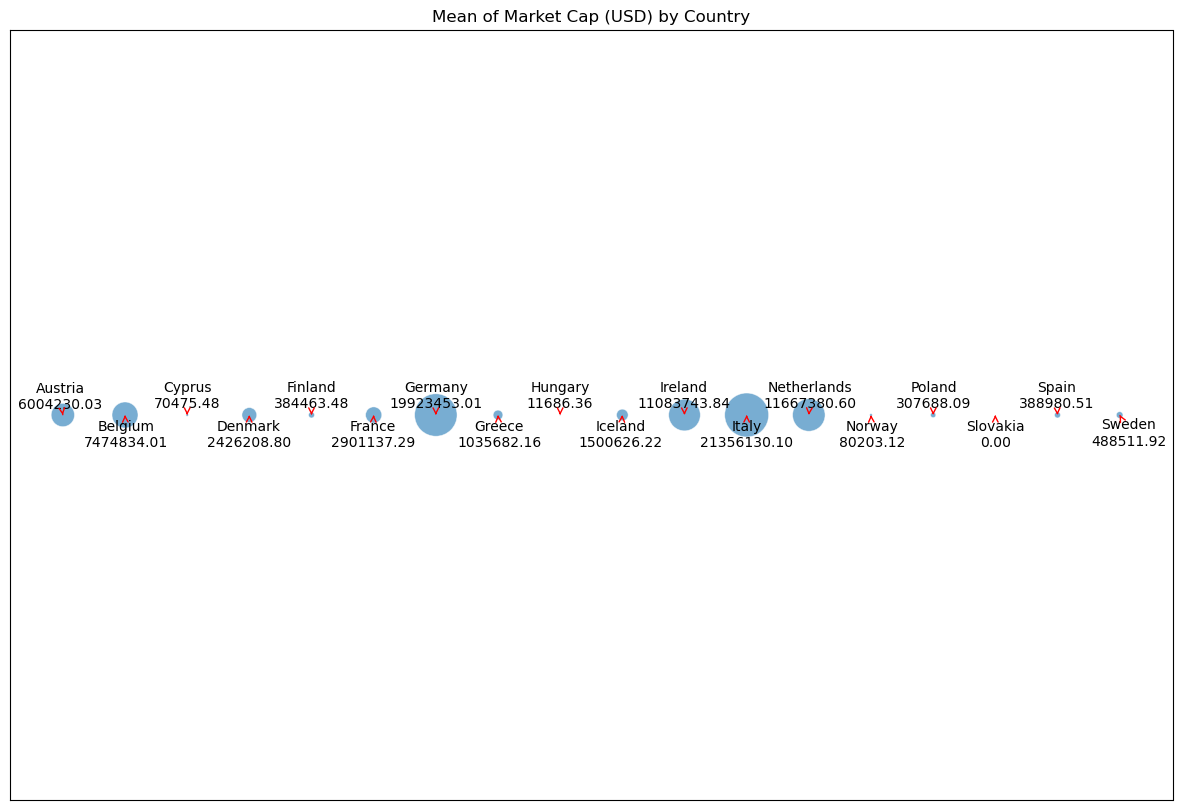

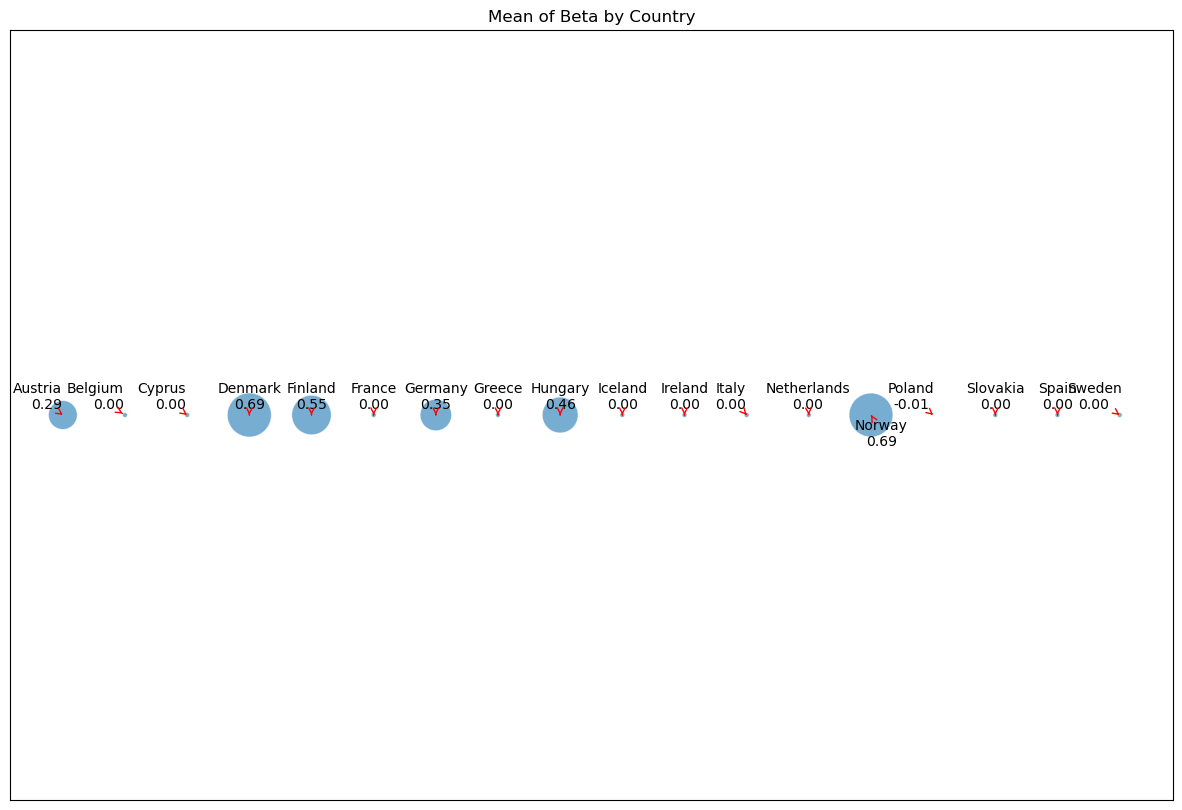

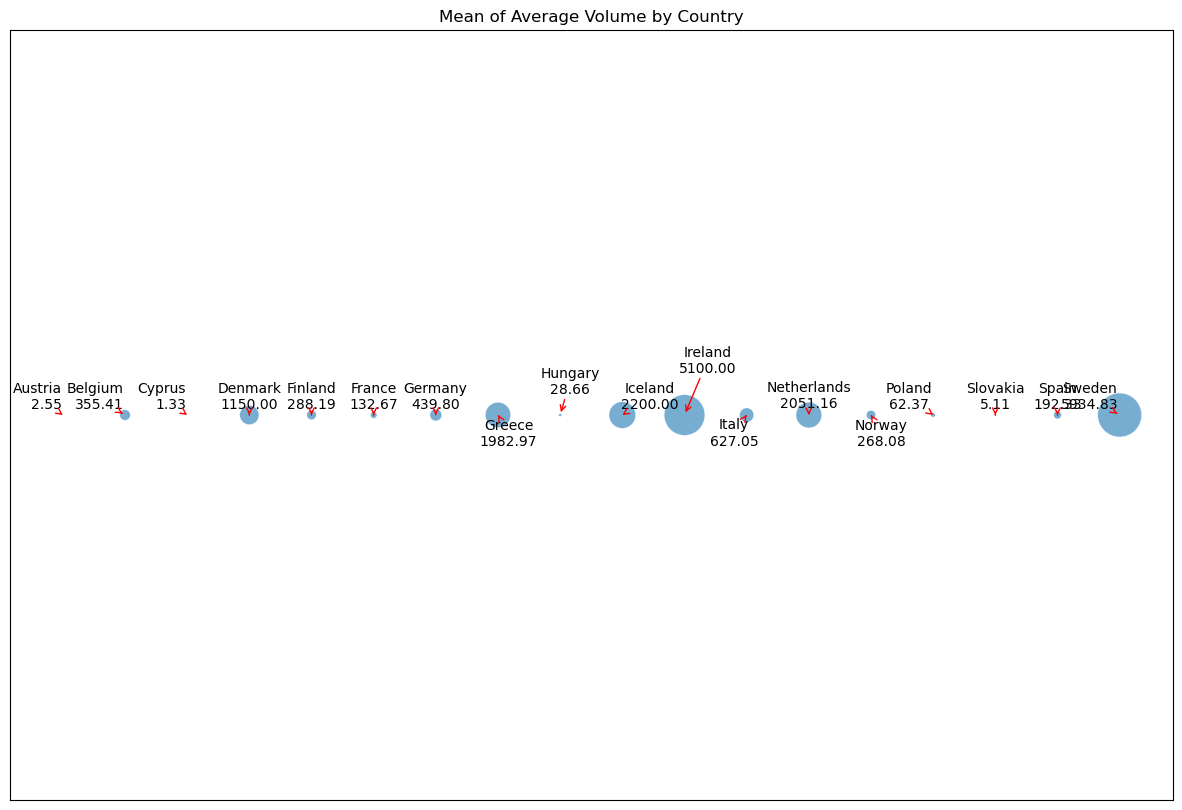

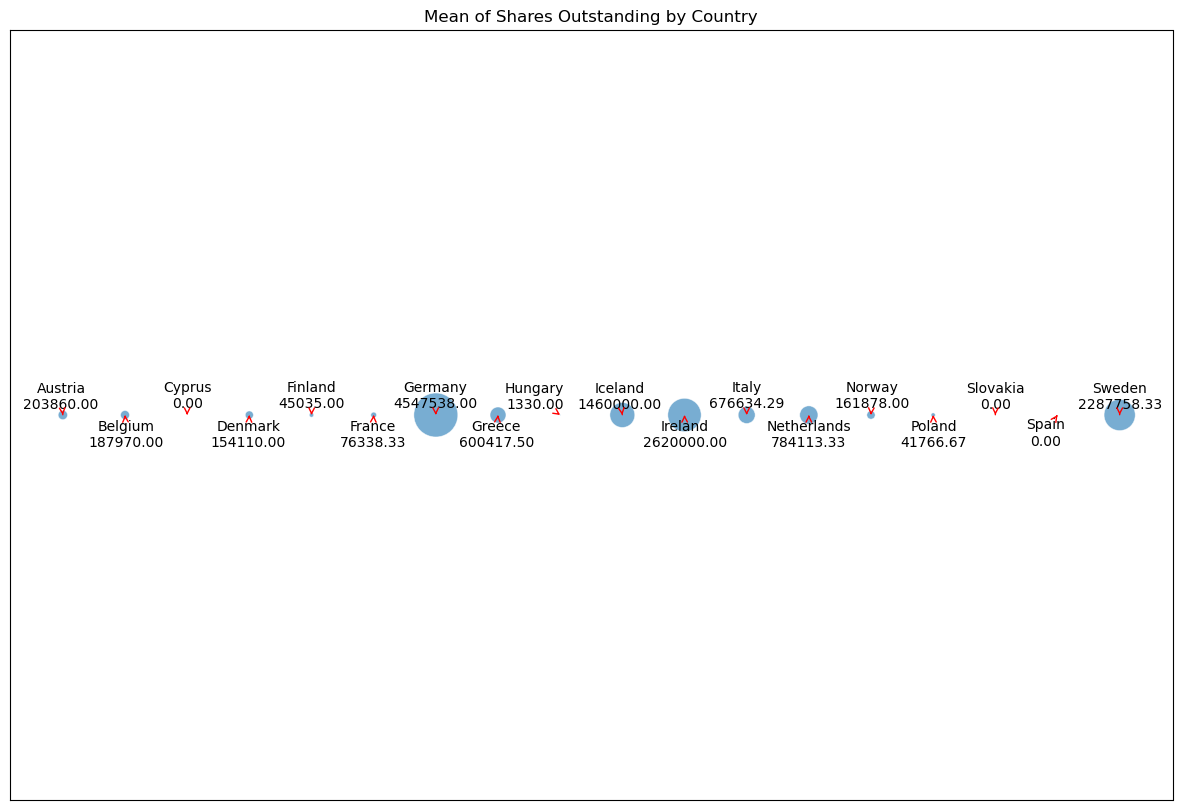

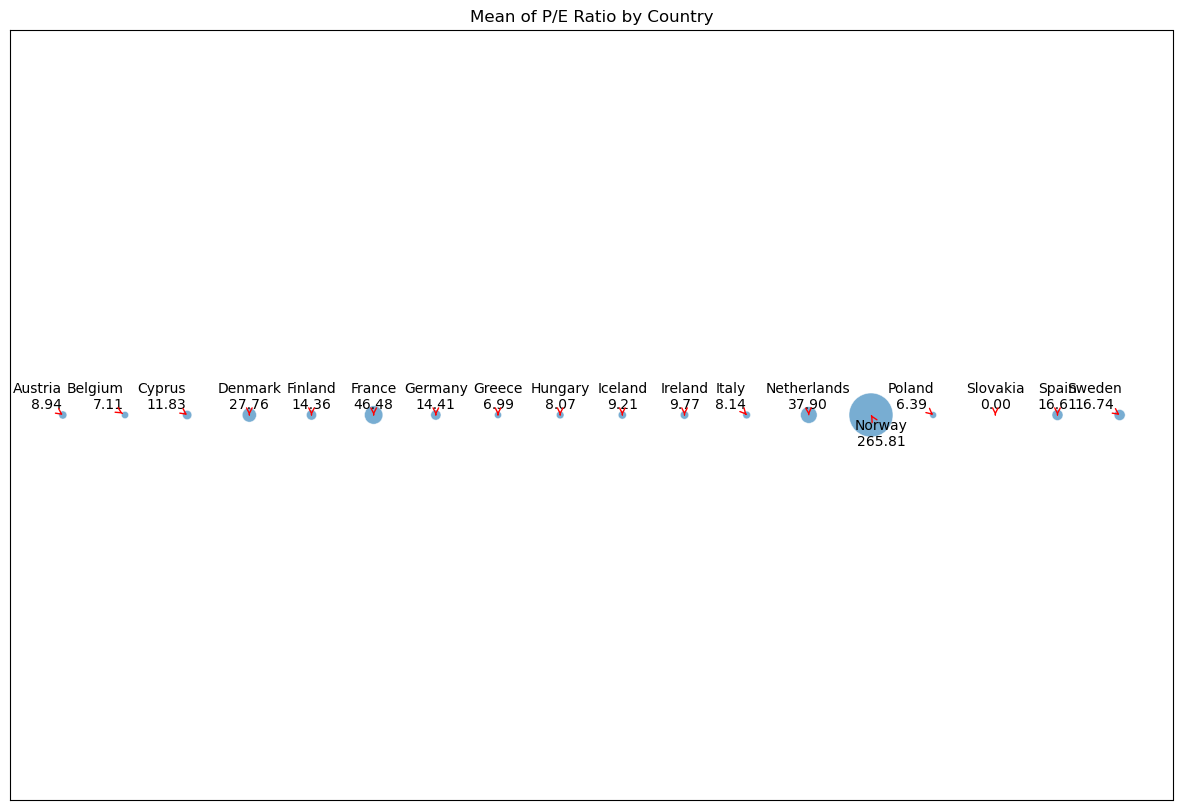

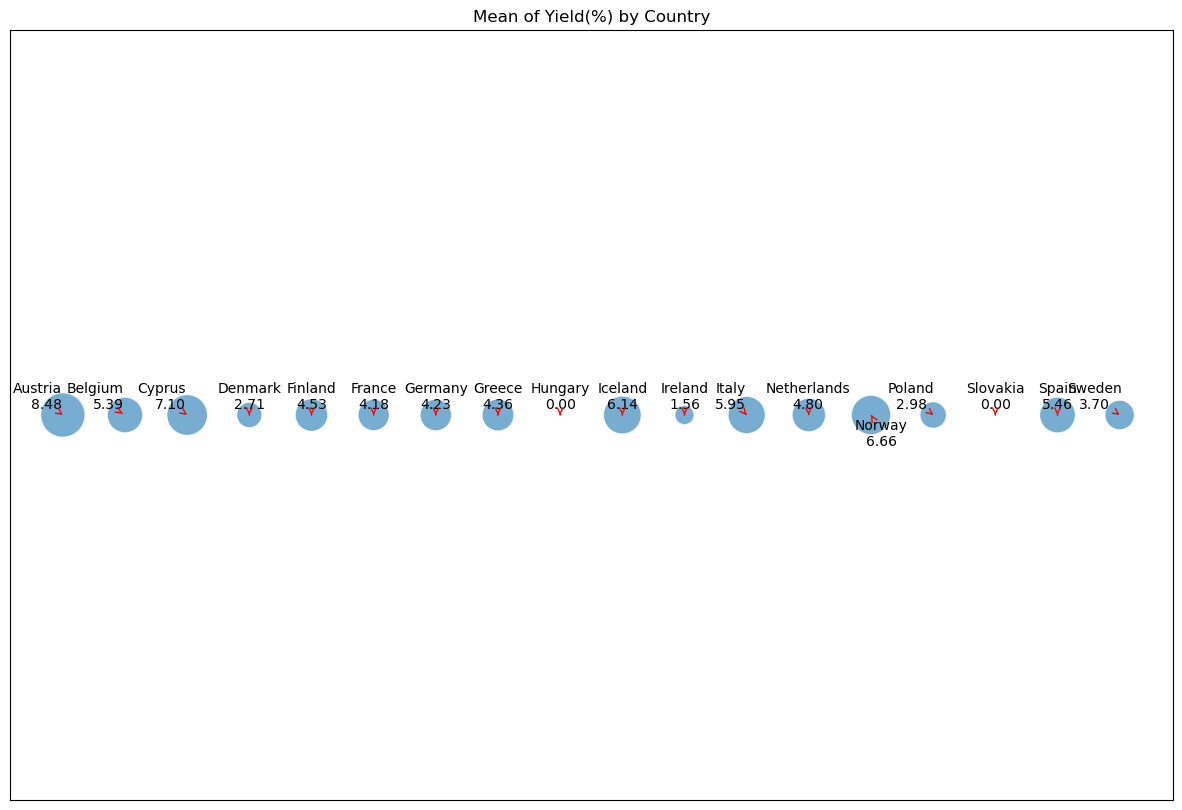

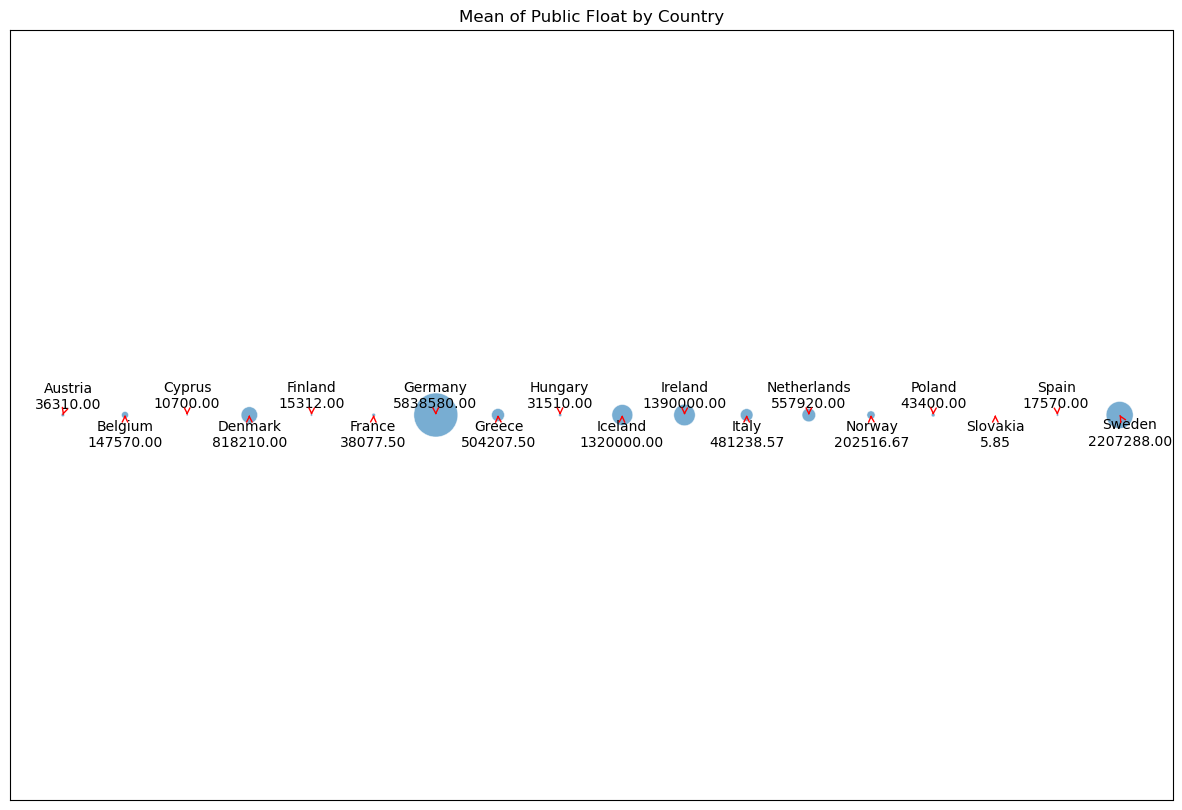

time: 12.8 s (started: 2023-09-12 15:50:18 +02:00)


In [38]:
from adjustText import adjust_text
Visual_Corporate.plot_bubble_chart_with_arrows(Financial_df1, 'Country', 'Market Cap', decimal_places=2, use_adjust_text=True, aggregation='mean', exclude_values=None, exclude_columns=None)

In [7]:
# Filter: df, column from witch get numeric columns, category reference, sub category (optional)
sort_financial_df = Visual_Corporate.financial_table_sorted(Financial_df1, 
                           to_col_number='Market Cap', 
                           main_cat_col='Country',
                           sub_cat_target_col=None,
                           sort_by='P/E Ratio',
                           ascending_order=False,
                           highlight_gradient=True,
                           main_cat_filter_value=None,
                           sub_cat_filter_value=None,
                           exclude_columns=None
                           )
sort_financial_df

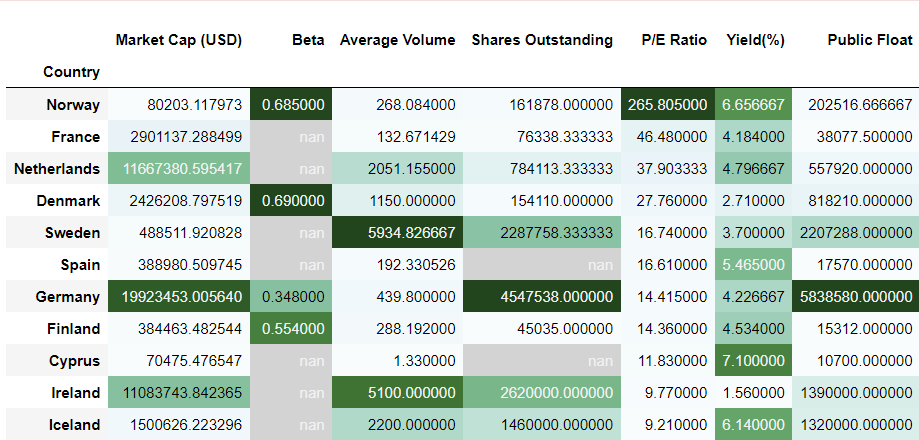

### <u>Corporate Analysis

In [ ]:
# Define the statements to be analyzed
# is_y: insome statements
# bs_y: balance sheet
# cf_y: cash flow
# rt_y: ratio table

In [84]:
# total rows
len(rt_y)

1046

time: 16 ms (started: 2023-09-07 23:22:24 +02:00)


**Nan values count**: just check, but not remove yet because we are going to make analysis considering all variables

In [85]:
rt_y.isna().sum()

Indices
Sector                         0
Super Sector                   0
Industry                       0
Country                        0
Exchange                       0
Ticker                         0
Company Name                   0
Currency Sign                  0
Year                           0
Liabilities to Assets         13
Debt to Liabilities          110
Debt to Equity               105
InterestExp to EBIT          121
Return On Equity               9
Total_Shareholders_Equity      9
Operating Margin              30
Capex to EBIT                211
D&A aprox to EBITDA           62
dtype: int64

time: 31 ms (started: 2023-09-07 23:22:27 +02:00)


In [695]:
# klib.missingval_plot(rt_y)

time: 0 ns (started: 2023-08-31 17:29:25 +02:00)


**Correlation matrix**

In [89]:
# klib.corr_plot()
klib.corr_mat(rt_y)

C:\Users\utente\anaconda3\Lib\site-packages\klib\describe.py:271: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  return corr.style.applymap(color_negative_red).format("{:.2f}", na_rep="-")


Indices,Liabilities to Assets,Debt to Liabilities,Debt to Equity,InterestExp to EBIT,Return On Equity,Total_Shareholders_Equity,Operating Margin,Capex to EBIT,D&A aprox to EBITDA
Indices,,,,,,,,,
Liabilities to Assets,1.00,-0.15,-0.05,0.04,-0.02,-0.56,0.02,-0.01,0.07
Debt to Liabilities,-0.15,1.00,0.15,0.10,-0.04,-0.04,0.03,0.09,-0.04
Debt to Equity,-0.05,0.15,1.00,0.02,0.03,0.18,0.01,-0.03,0.15
InterestExp to EBIT,0.04,0.10,0.02,1.00,-0.01,0.00,-0.02,0.56,0.17
Return On Equity,-0.02,-0.04,0.03,-0.01,1.00,0.14,0.04,-0.01,0.01
Total_Shareholders_Equity,-0.56,-0.04,0.18,0.00,0.14,1.00,0.00,-0.04,-0.01
Operating Margin,0.02,0.03,0.01,-0.02,0.04,0.00,1.00,-0.00,0.01
Capex to EBIT,-0.01,0.09,-0.03,0.56,-0.01,-0.04,-0.00,1.00,0.15
D&A aprox to EBITDA,0.07,-0.04,0.15,0.17,0.01,-0.01,0.01,0.15,1.00


time: 281 ms (started: 2023-09-07 23:42:40 +02:00)


**Describe**

In [90]:
rt_y.describe()

Indices,Liabilities to Assets,Debt to Liabilities,Debt to Equity,InterestExp to EBIT,Return On Equity,Total_Shareholders_Equity,Operating Margin,Capex to EBIT,D&A aprox to EBITDA
count,1033.00,936.00,941.00,925.00,1037.00,1037.00,1016.00,835.00,984.00
mean,0.73,0.30,1.80,0.97,-0.06,0.97,-9.52,1.86,0.19
std,1.00,0.29,8.57,3.19,2.40,0.24,160.78,15.77,0.45
min,0.00,0.00,-9.99,-0.35,-71.95,-1.00,-3410.00,0.00,-1.00
25%,0.40,0.06,0.18,0.05,0.02,1.00,0.05,0.05,-0.06
50%,0.84,0.21,0.67,0.27,0.08,1.00,0.20,0.13,0.25
75%,0.91,0.44,1.97,0.82,0.14,1.00,0.32,0.32,0.51
max,21.44,2.99,216.60,55.00,14.47,1.00,634.45,340.20,0.99


time: 157 ms (started: 2023-09-07 23:43:11 +02:00)


**Box Plot: corporate outliers analysis for each index**

In [98]:
# pip install --upgrade seaborn

time: 0 ns (started: 2023-09-07 23:49:41 +02:00)


C:\Users\utente\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\utente\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\utente\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\utente\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

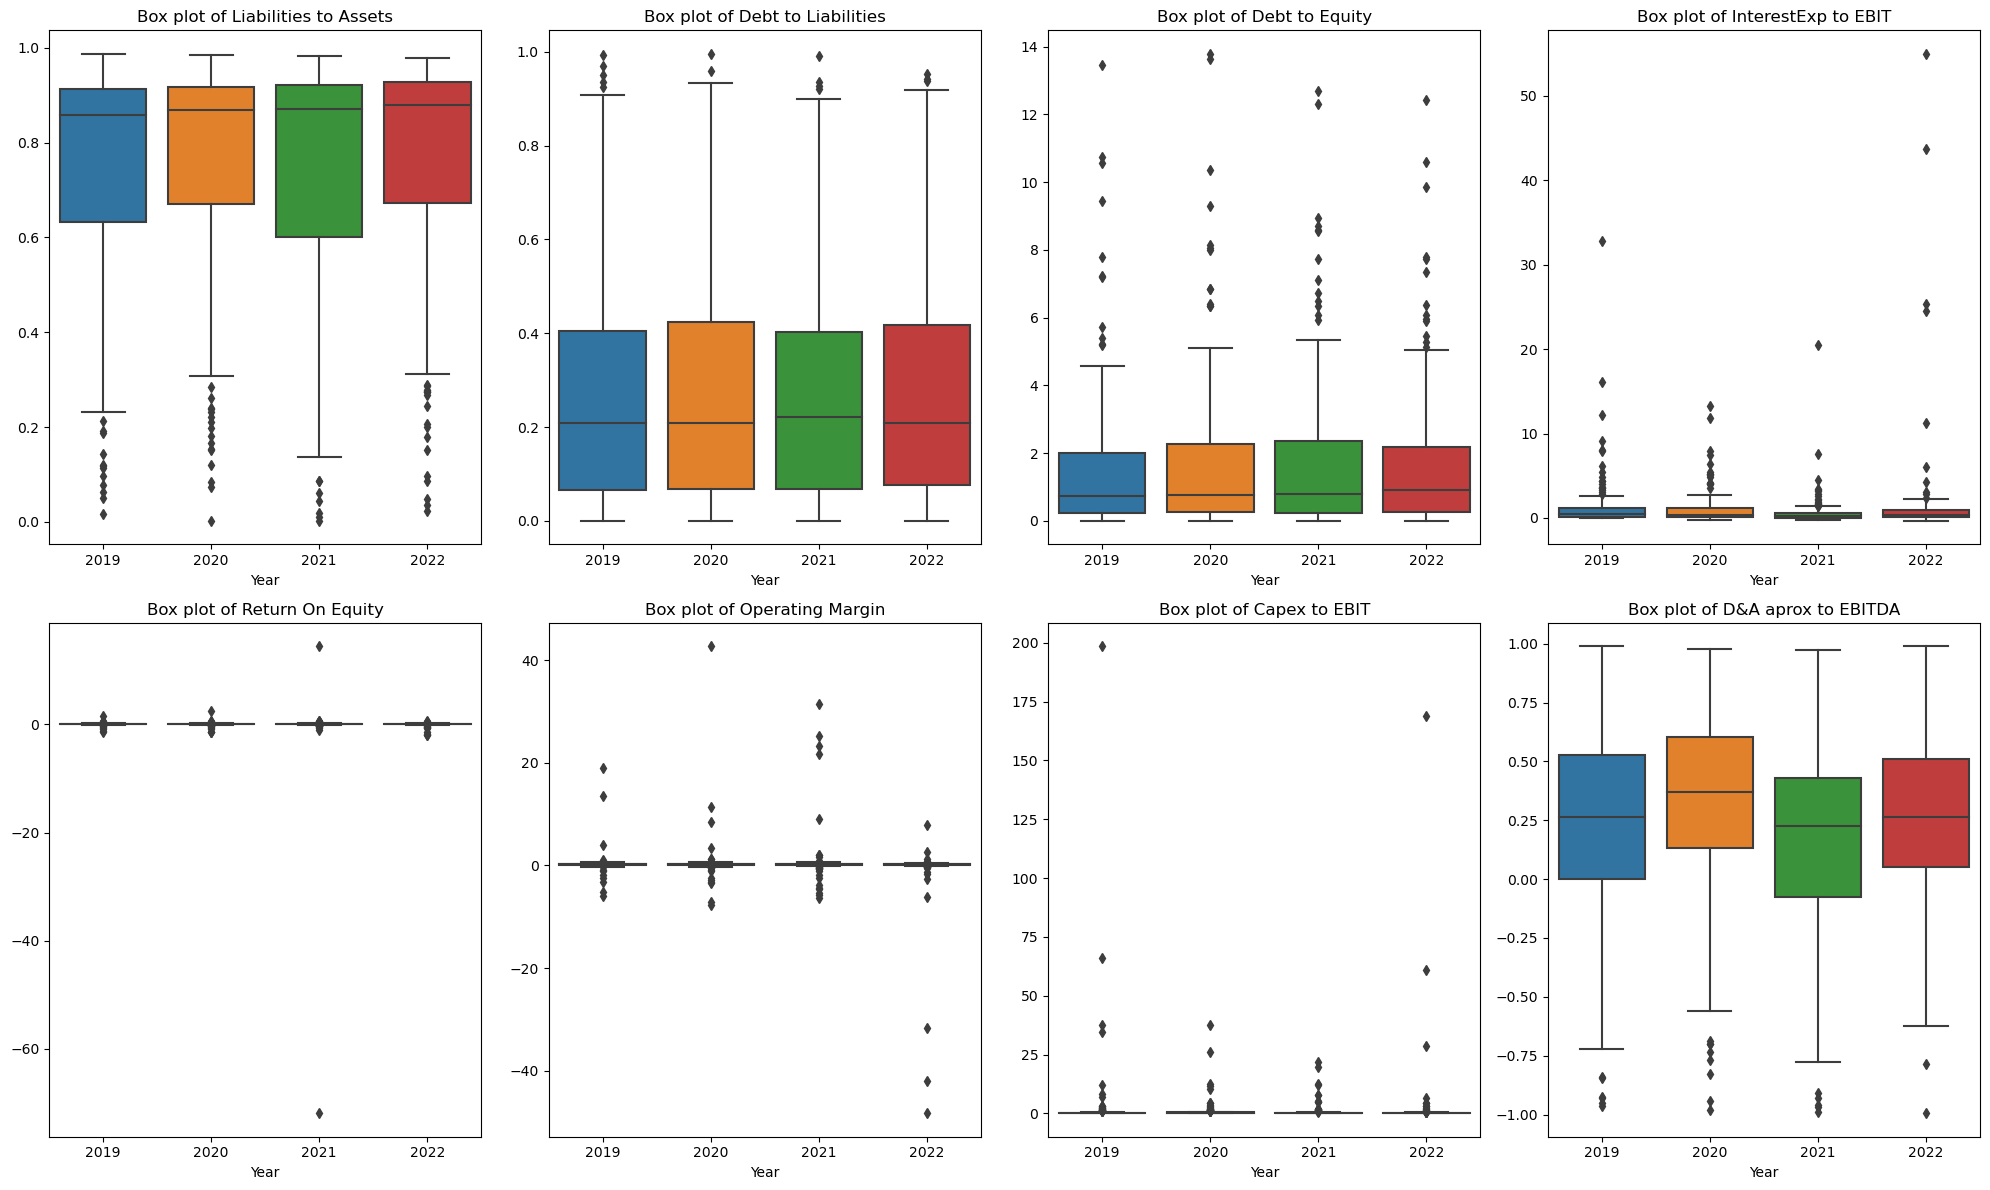

time: 3.58 s (started: 2023-09-12 17:02:11 +02:00)


In [40]:
# pass: df, 'Year', number of rows to use to show plots
Visual_Corporate.box_plots(rt_y, last_col='Year', rows_plot=2, exclude_values=[-9.99], exclude_columns='Total_Shareholders_Equity')

* Also for help box plots, following will be showed dataframe will show data with hilight moving intensity color each values.
* Dataframe showe all companies available about sector selected.
* The goal is to make easier find potentially anomalies and useful data about companies trend

**Table: intensity color change by values considering each column by intself**

In [8]:
styled_df = Visual_Corporate.gradient_based_on_value(rt_y, 'Year', exclude_columns=['Total_Shareholders_Equity'], exclude_values=[-9.99])
styled_df

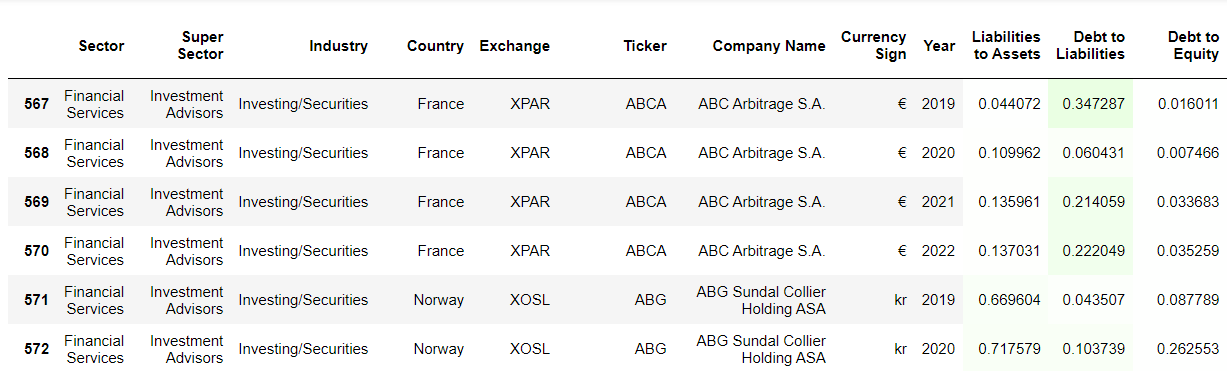

**Bubble Chart: corporate trend mean for each index during years**

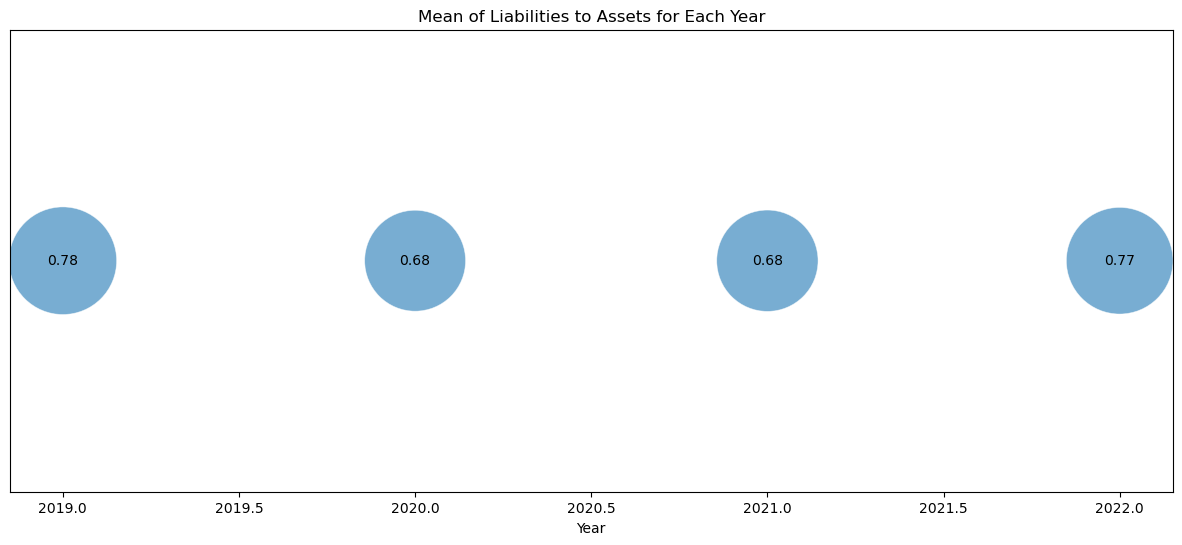

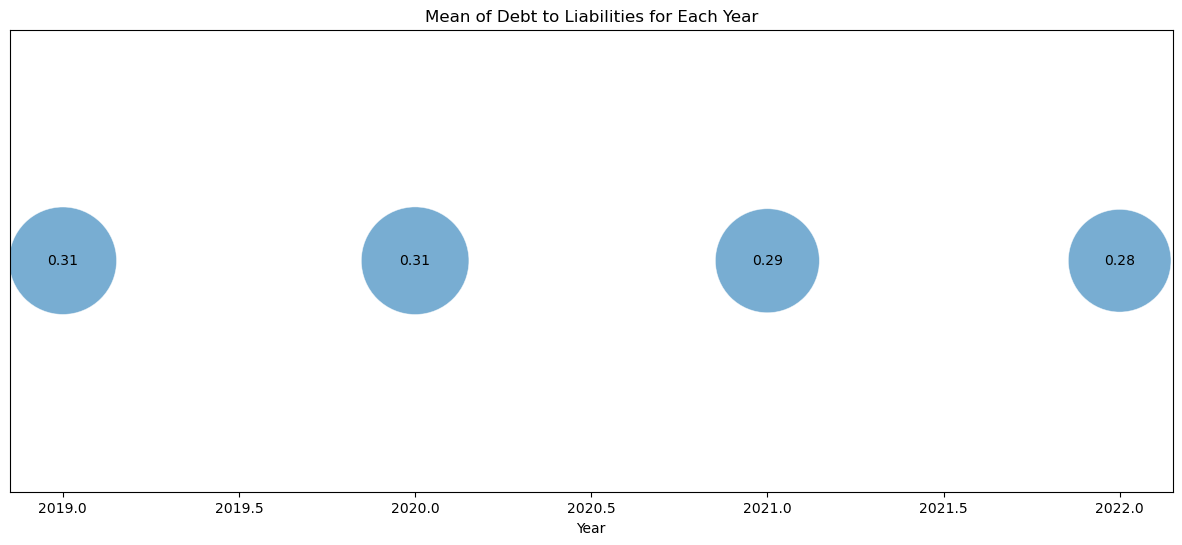

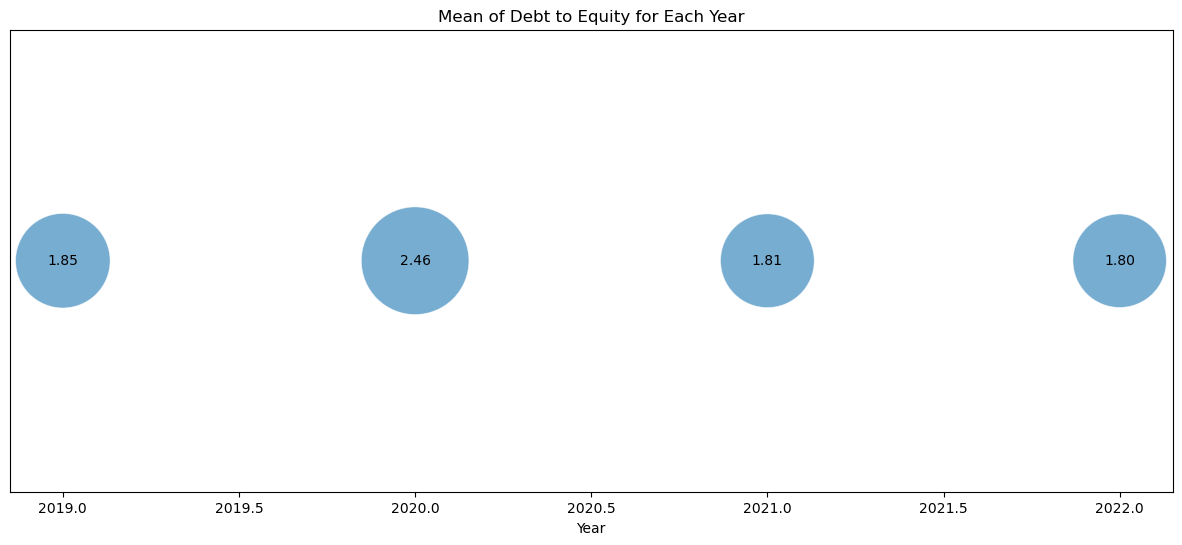

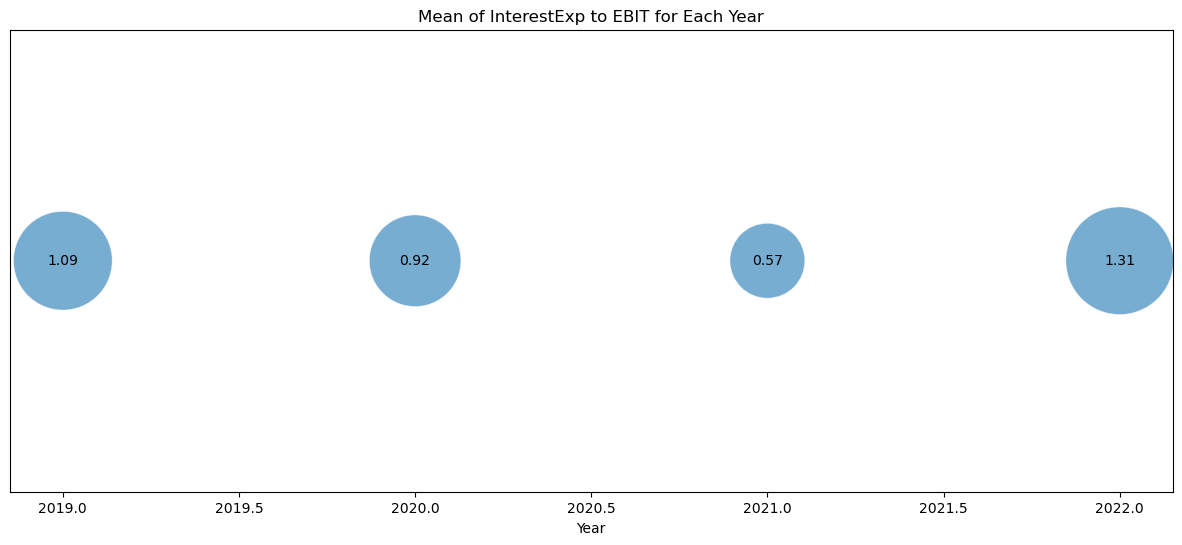

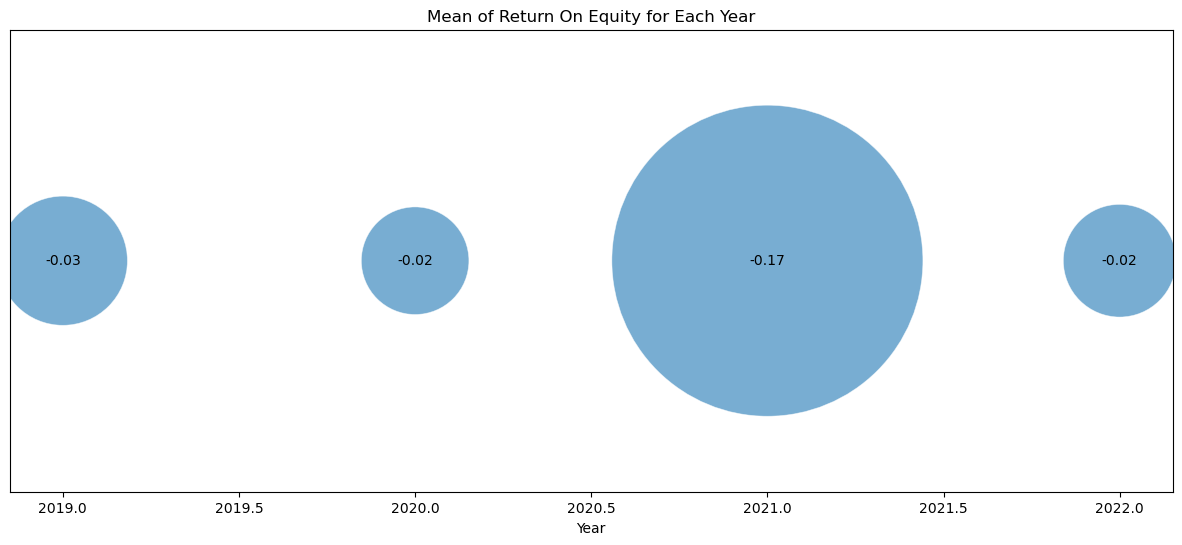

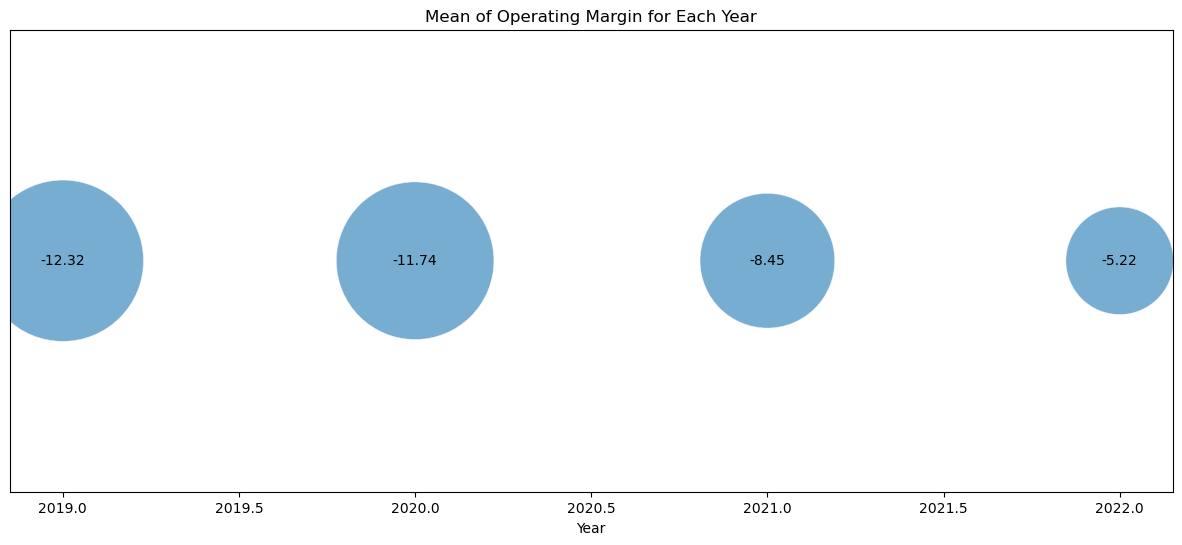

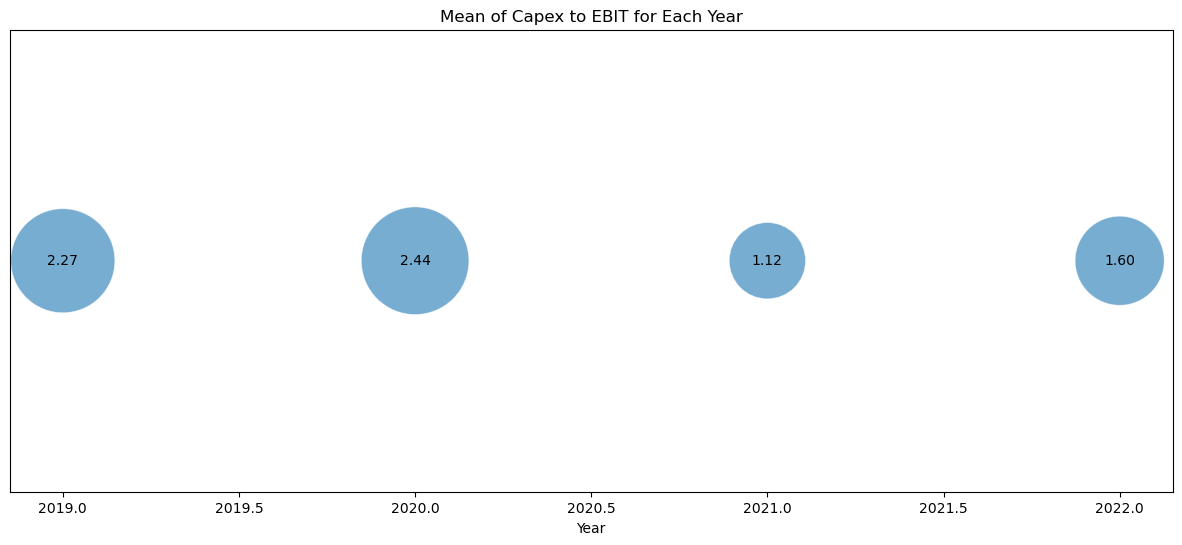

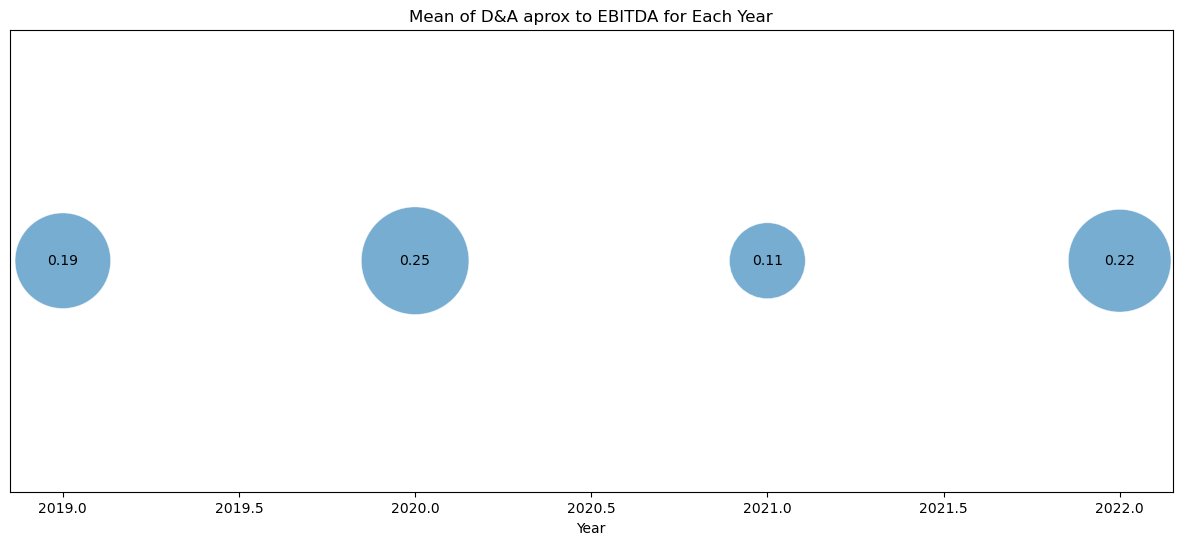

time: 1.89 s (started: 2023-09-12 17:04:25 +02:00)


In [42]:
Visual_Corporate.plot_single_bubble_chart(rt_y, last_col='Year', aggregation='mean', filter_column=None, filter_value=None, exclude_values=[-9.99], exclude_columns='Total_Shareholders_Equity')

**Bubble Chart: mean by each index and category**

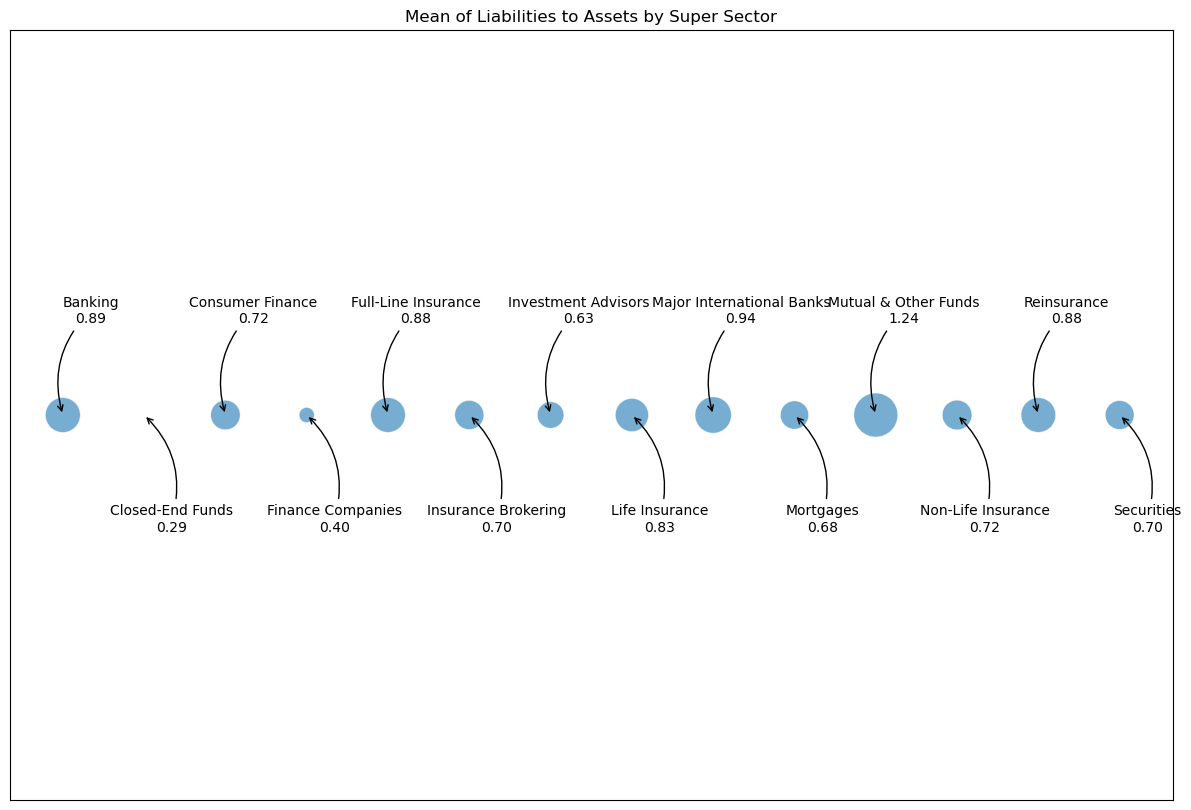

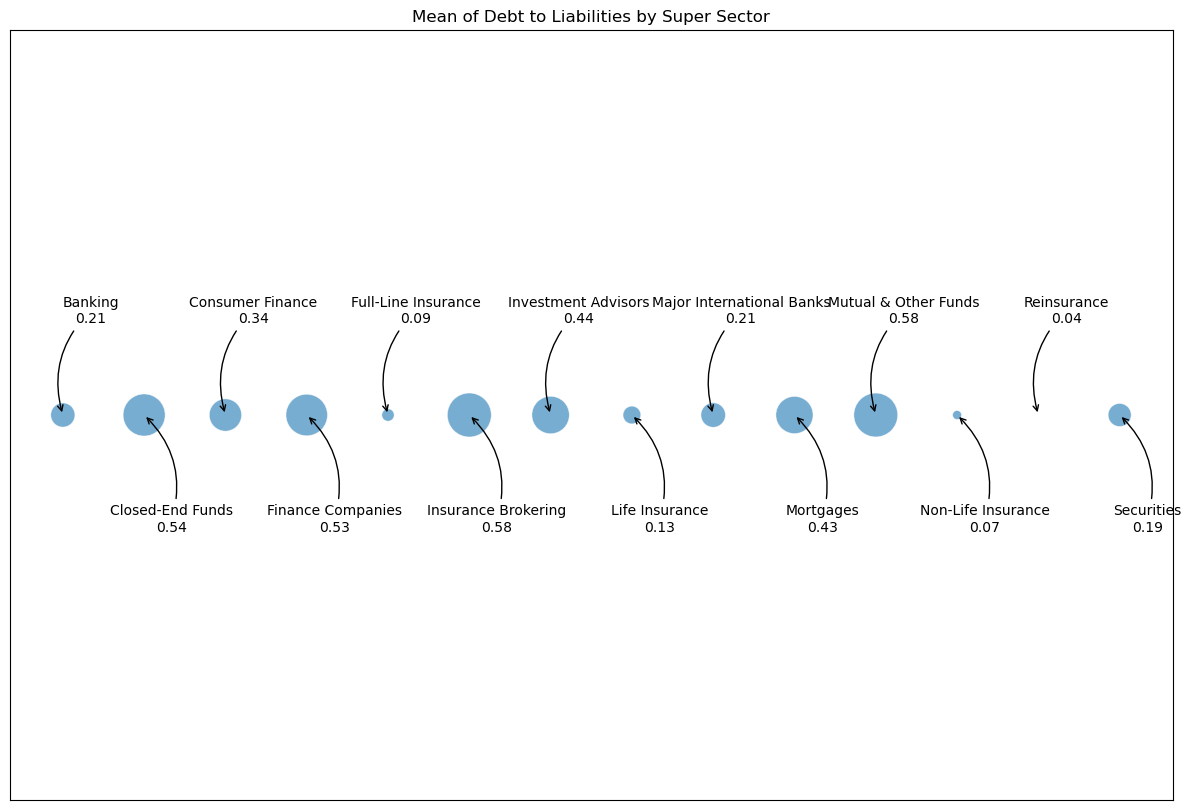

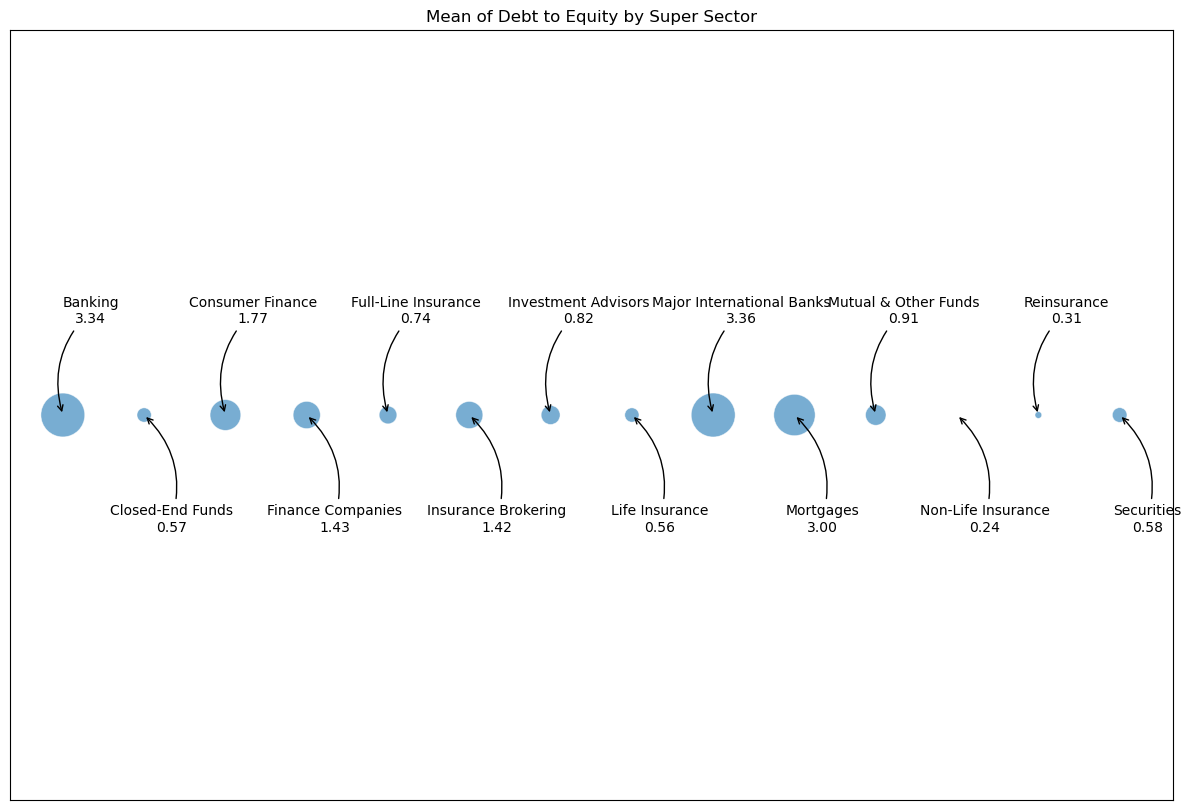

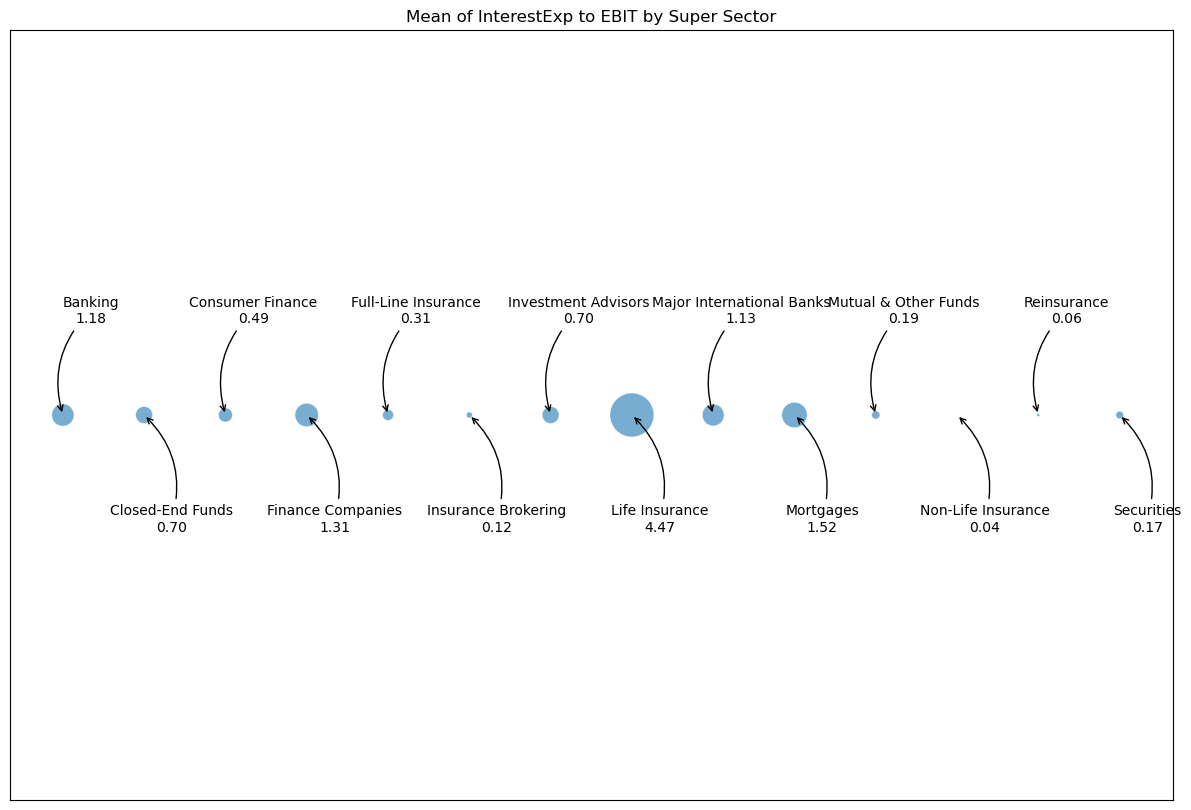

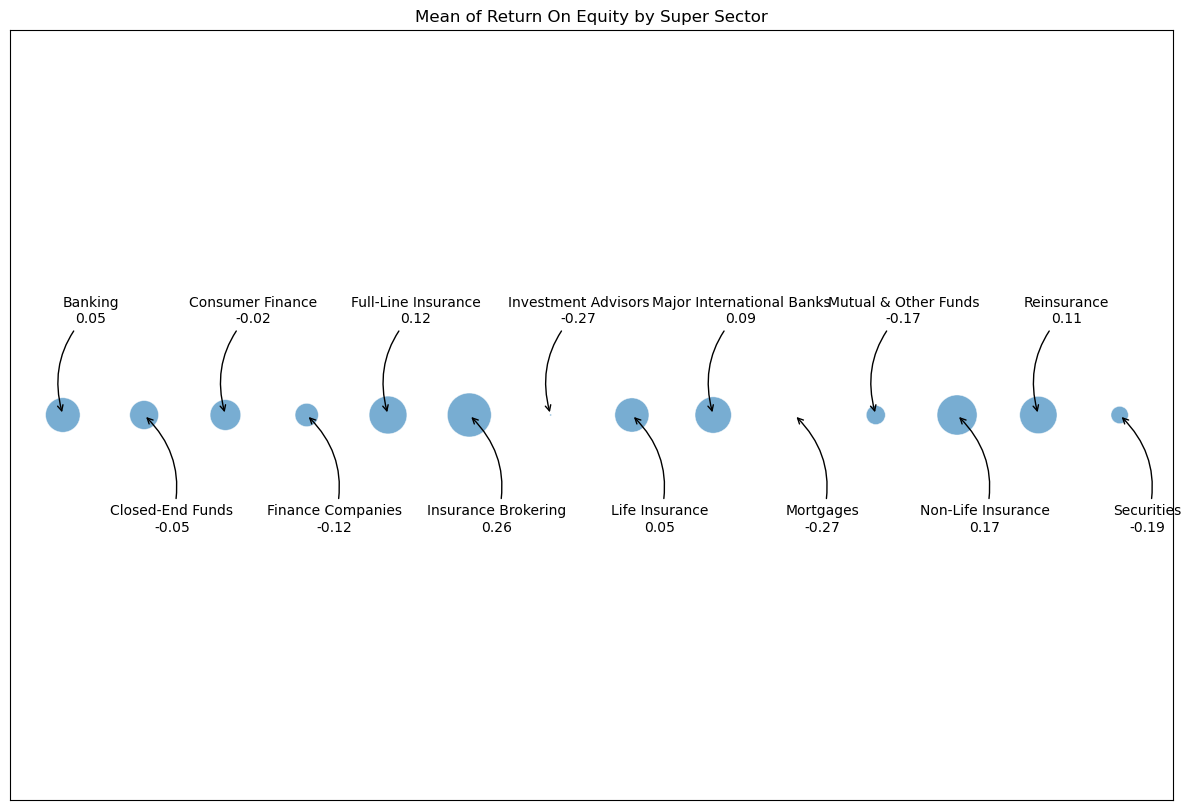

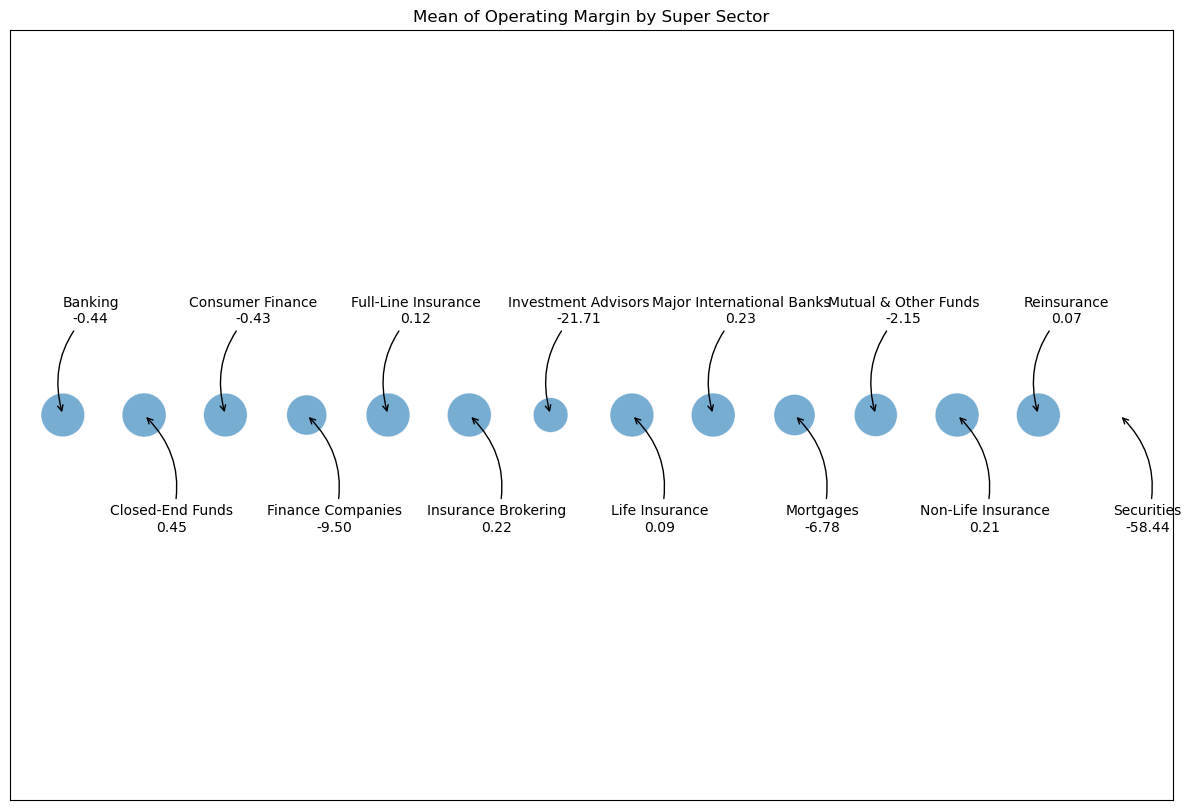

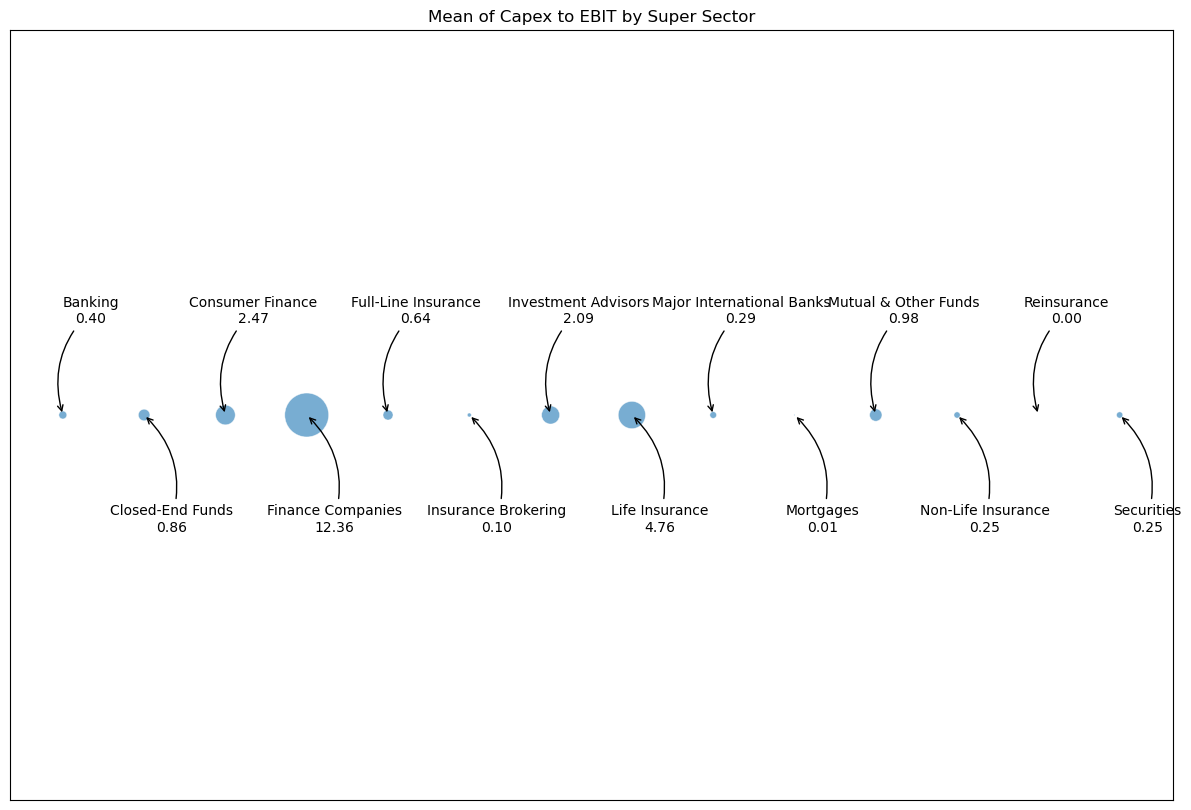

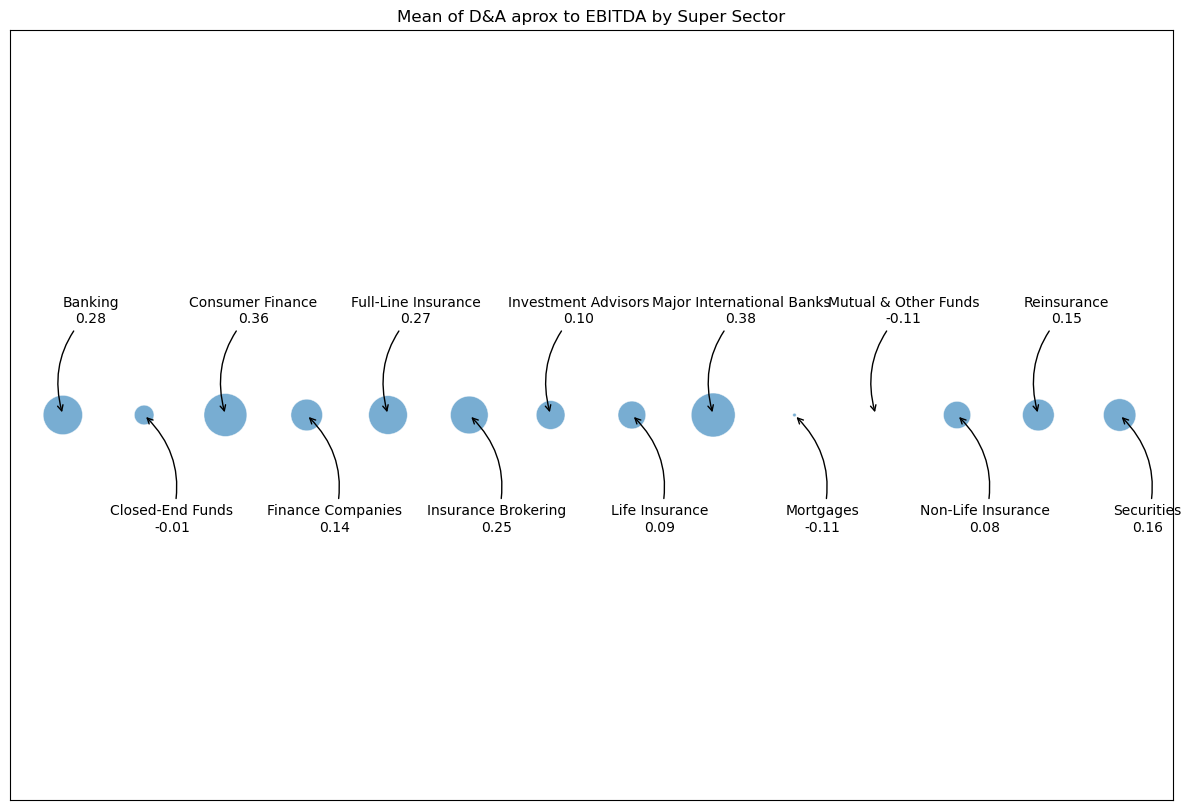

time: 6.03 s (started: 2023-09-12 17:04:38 +02:00)


In [43]:
Visual_Corporate.plot_bubble_chart_with_arrows(rt_y, 'Super Sector', 'Year', decimal_places=2, use_adjust_text=False, aggregation='mean', exclude_values=[-9.99], exclude_columns='Total_Shareholders_Equity')

In [9]:
# Filter: df, column from witch get numeric columns, category reference, sub category (optional)
sort_corporate_df = financial_table_sorted(rt_y, to_col_number='Year',
                           main_cat_col='Super Sector',
                           sub_cat_target_col='Year',
                           sort_by='Year',
                           ascending_order=True,
                           highlight_gradient=True,
                           main_cat_filter_value=None,
                           sub_cat_filter_value=2022,
                           exclude_columns='Total_Shareholders_Equity',
                           exclude_view_columns='Total_Shareholders_Equity'
                           )
sort_corporate_df

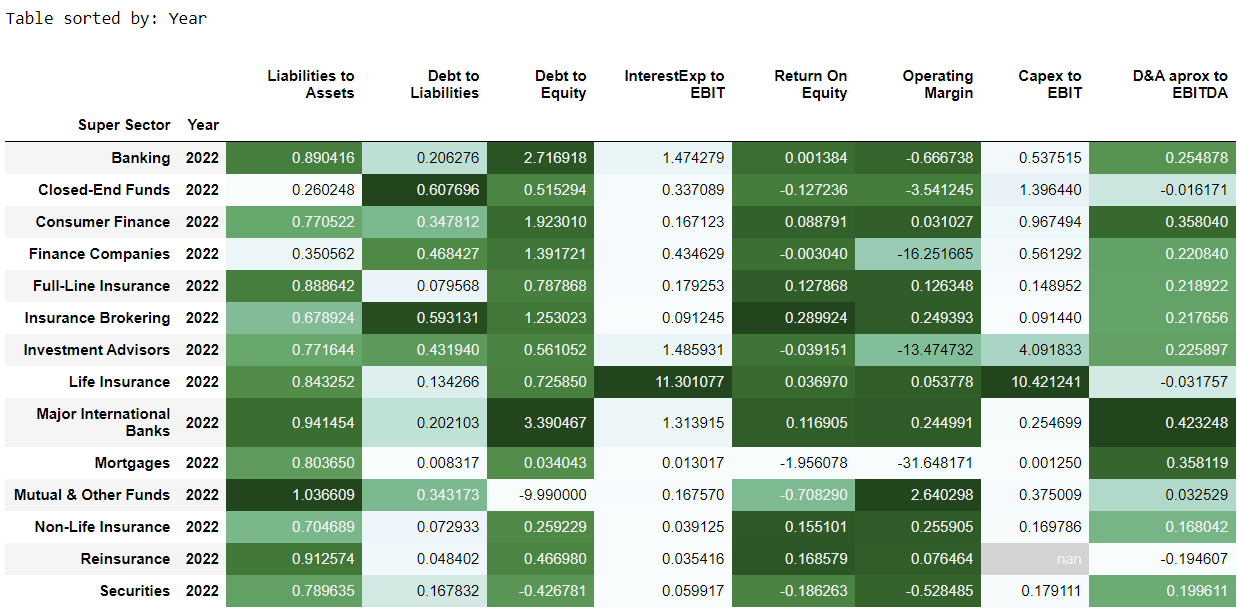

<!--  -->

<!--  -->

## Read Dataframe from GDrive

About the dataframe:
- it's available to anyone (just run the cell to get it)
- It's about Ratio Table statements. Especially, it collects all listed European companies about "Financial Services" sector which start by "A" and "B" letters

In [46]:
# Get data from df shared
def read_gdrive_to_df(file_id):
    """
    Read an Excel file from Google Drive using its file ID and return a DataFrame.
    """
    base_url = f'https://drive.google.com/file/d/{file_id}/view?usp=sharing'
    download_url = 'https://drive.google.com/uc?id=' + base_url.split('/')[-2]
    return pd.read_excel(download_url, index_col=0)

# File IDs
link_file_2 = '1zWzIP_58rx2c5kys3WkWhG4jHW4tDctu' # file code countries grouping

# Read files using the function
aggregated_countries = read_gdrive_to_df(link_file_2)

time: 6.61 s (started: 2023-09-12 17:05:43 +02:00)


## Preparation to Data Imputation

Steps:
- NaN values dataframe check potentially columns to remove (based on custom threshold)
- Define columns to keep
- Skewness
- Encoding
- Test imputation models
- Impute nan values using selected method

## Check -9.99
-9.99 refers to values setted by model just for values appeared as anomalies

**a) Count -9.99 values in dataset**

In [48]:
def count_value(df, value):
    """
    Count how many times a specific value appears in a dataframe,
    both in total and as a percentage for each column.

    Returns:
    total_count: total value count in the dataframe.
    column_percentages : percentage of the value in each column.
    """
    
    total_count = (df == value).sum().sum()
    
    column_counts = (df == value).sum()
    column_totals = df.count()
    
    column_percentages = (column_counts / column_totals) * 100
    
    return total_count, column_percentages

# Call
total_count, column_percentages = count_value(rt_y, -9.99)

time: 0 ns (started: 2023-09-12 17:05:50 +02:00)


In [420]:
total_count

15

time: 16 ms (started: 2023-09-08 18:17:27 +02:00)


In [49]:
column_percentages

Sector                      0.00
Super Sector                0.00
Industry                    0.00
Country                     0.00
Exchange                    0.00
Ticker                      0.00
Company Name                0.00
Currency Sign               0.00
Year                        0.00
Liabilities to Assets       0.00
Debt to Liabilities         0.00
Debt to Equity              1.59
InterestExp to EBIT         0.00
Return On Equity            0.00
Total_Shareholders_Equity   0.00
Operating Margin            0.00
Capex to EBIT               0.00
D&A aprox to EBITDA         0.00
dtype: float64

time: 0 ns (started: 2023-09-12 17:05:50 +02:00)


**b) Replace -9.99 with NaN**

In [50]:
def replace_with_nan(df, value_to_replace):
    return df.replace(value_to_replace, np.nan)

rt_y1 = replace_with_nan(rt_y, -9.99)

time: 15 ms (started: 2023-09-12 17:05:51 +02:00)


In [51]:
# Check if values replaced
total_count, column_percentages = count_value(rt_y1, -9.99)
total_count

0

time: 0 ns (started: 2023-09-12 17:05:52 +02:00)


# Data distribution

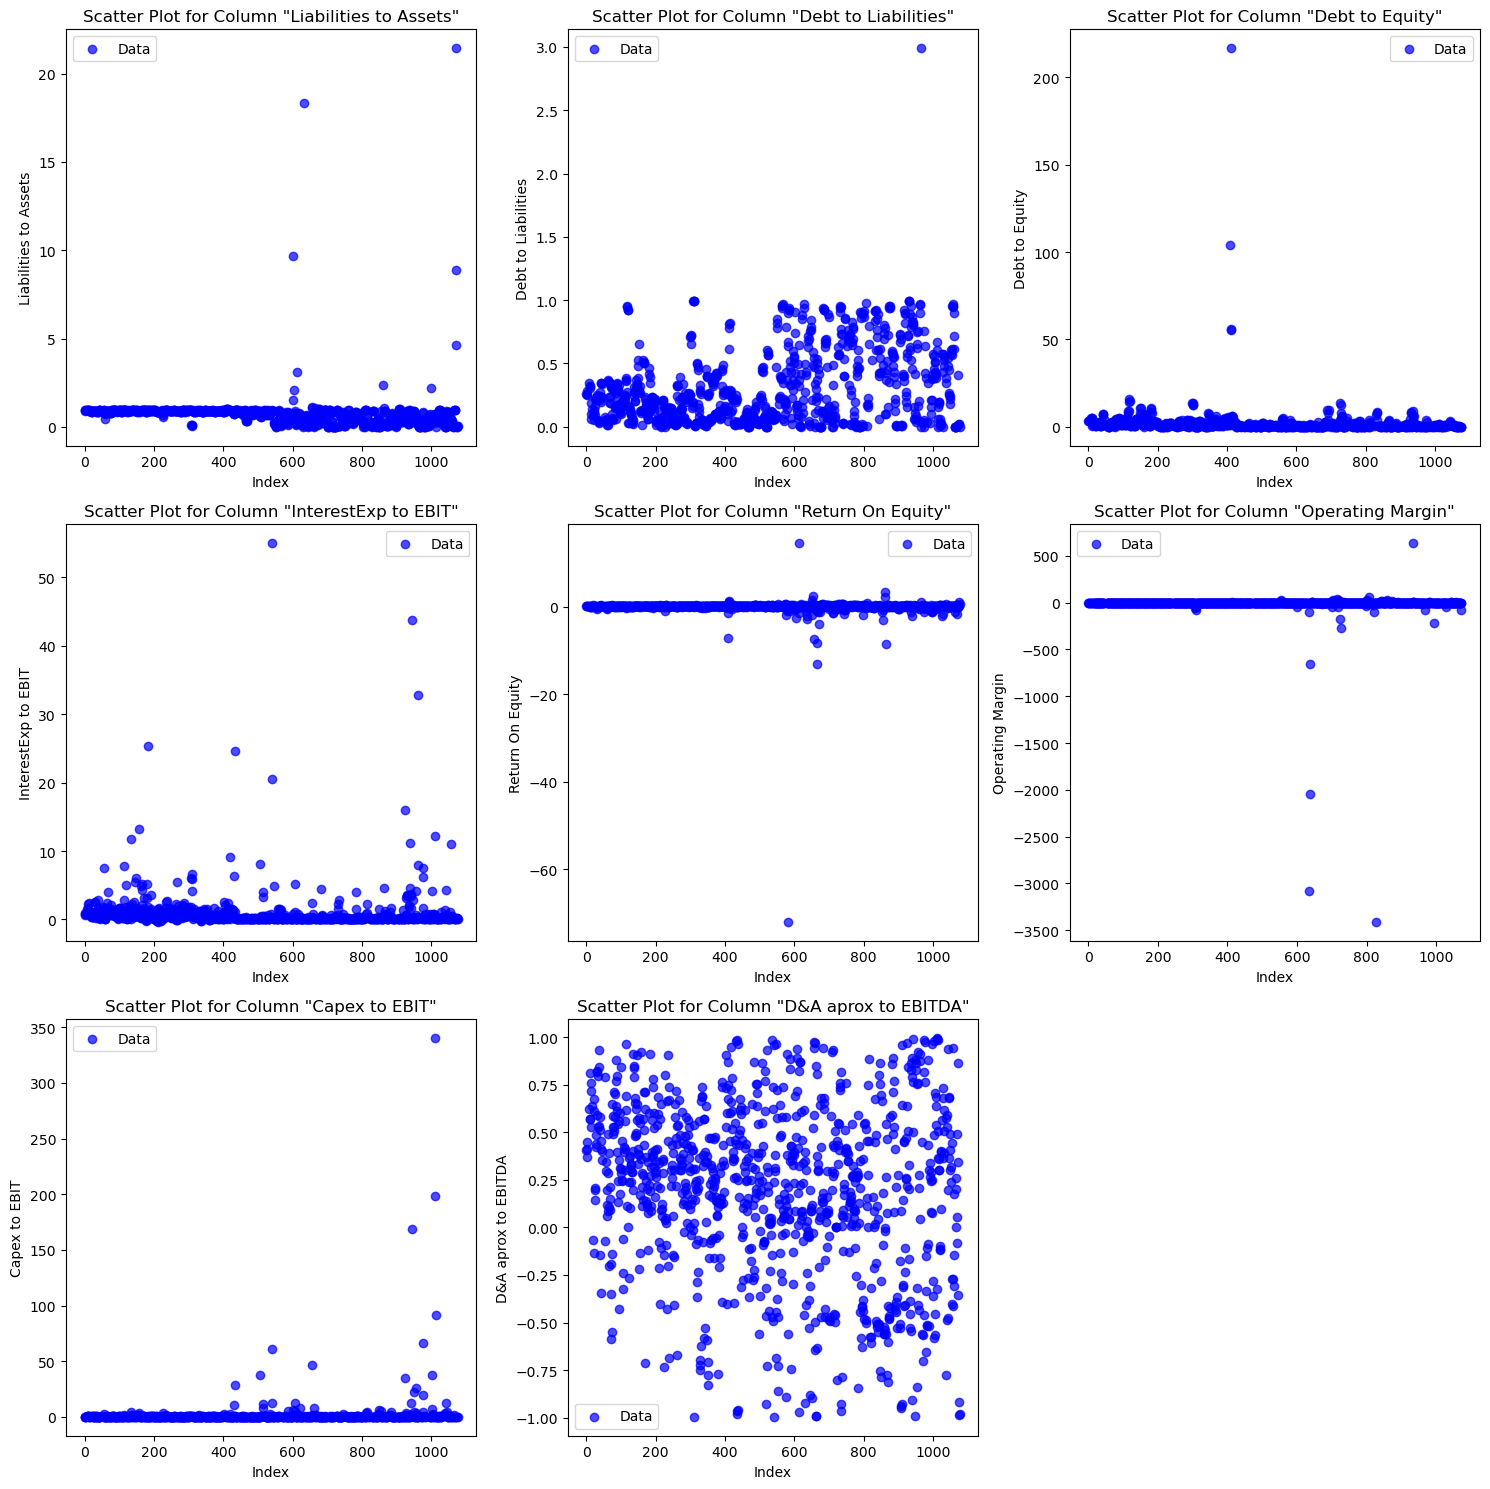

time: 3.31 s (started: 2023-09-12 19:33:26 +02:00)


In [125]:
Visual_Corporate.plot_data_distribution(rt_y1, exclude_columns=['Year','Total_Shareholders_Equity'], plots_per_row=3)

# IsolationForest

this model will be used to check outliers. The threshold to get X percentage of outliers is setted by "auto" (automated analysis by model), but you can set custom (could use F1 score to get param).

In [53]:
df_isofor_outliers = Visual_Corporate.isolation_forest(rt_y1, 
                     exclude_columns='Total_Shareholders_Equity', 
                     group_column=None, 
                     replace_nan_with_zero=True, 
                     replace_values_with_zero=None, 
                     threshold="auto")

time: 2.19 s (started: 2023-09-12 17:06:13 +02:00)


In [193]:
# df_isofor_outliers

time: 0 ns (started: 2023-09-08 10:17:11 +02:00)


<u>Modelling data with IsoFor predictions just to make data more readable
   - -1: outlier
   - 1: non outlier

In [1]:
# pd.options.display.float_format = '{:.2f}'.format
# df_iso_for = Visual_Corporate.iso_for_alternate_columns(df_isofor_outliers, exclude_columns=['Total_Shareholders_Equity'])

## Outliers analysis

explanation of next visualizations
* **Graph Data** distribution and outliers hilighted
* **Bubble Graph**, formula equal to: total (1) - total (-1). So big bubble contains less outliers
* **Box Plots**: check outliers compared to quantile distribution

### Graph Data distribution and outliers highlited

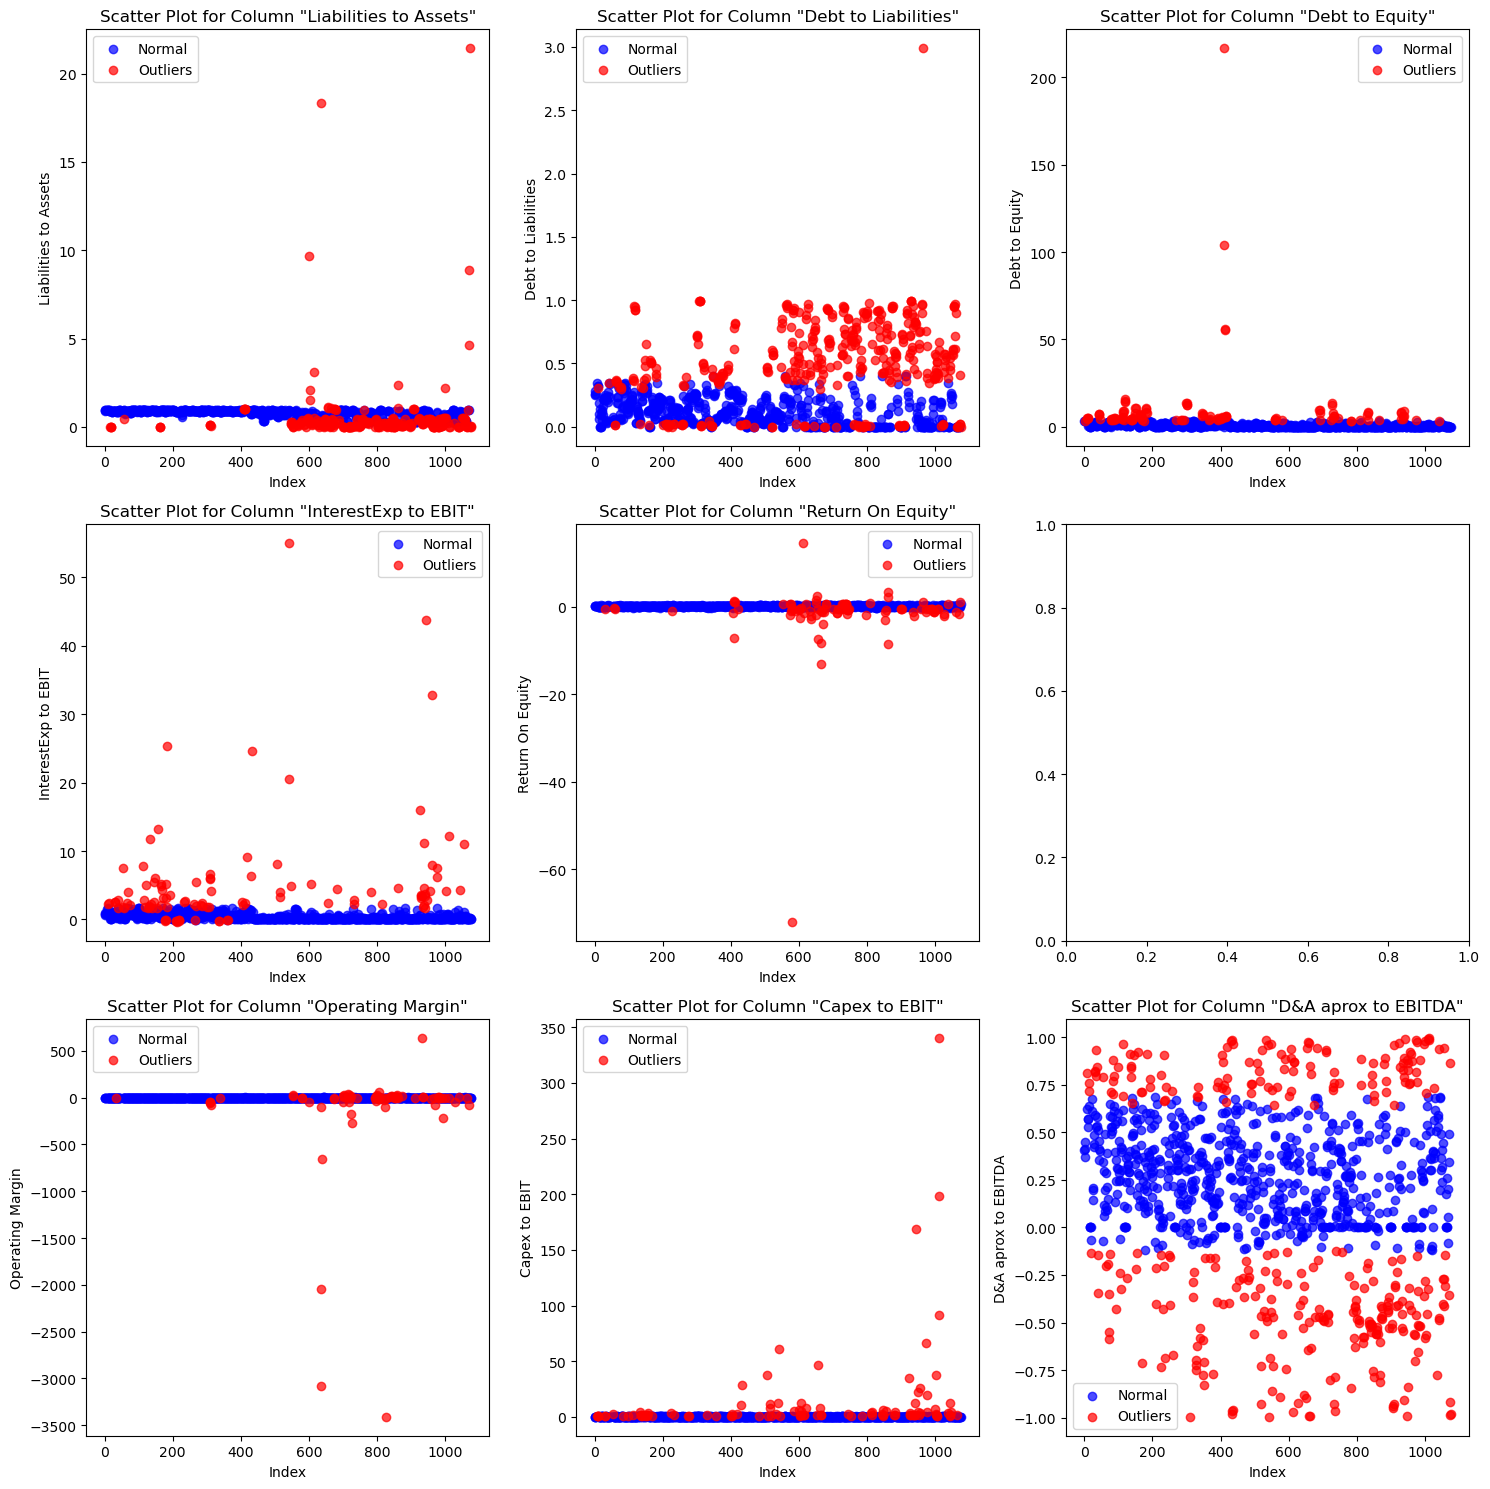

time: 4.36 s (started: 2023-09-12 17:11:30 +02:00)


In [61]:
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import matplotlib.pyplot as plt

# Call (empty graph if because has been decided rows but not enough columns to fill)
Visual_Corporate.plot_outliers_scatter(df_isofor_outliers, exclude_columns=['Year'], plots_per_row=3)

### Get dataframe with just outliers

In [62]:
# Call
df_outlier = Visual_Corporate.outliers_df_iso_for(df_iso_for, exclude_columns=[]) # 'Total_Shareholders_Equity' already passed previously

time: 0 ns (started: 2023-09-12 17:12:04 +02:00)


In [64]:
df_outlier.head()

,Sector,Super Sector,Industry,Country,Exchange,Ticker,Company Name,Currency Sign,Year,Liabilities to Assets,Debt to Liabilities,Debt to Equity,InterestExp to EBIT,Return On Equity,Operating Margin,Capex to EBIT,D&A aprox to EBITDA
567,Financial Services,Investment Advisors,Investing/Securities,France,XPAR,ABCA,ABC Arbitrage S.A.,€,2019.00,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
568,Financial Services,Investment Advisors,Investing/Securities,France,XPAR,ABCA,ABC Arbitrage S.A.,€,2020.00,0.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
569,Financial Services,Investment Advisors,Investing/Securities,France,XPAR,ABCA,ABC Arbitrage S.A.,€,2021.00,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
570,Financial Services,Investment Advisors,Investing/Securities,France,XPAR,ABCA,ABC Arbitrage S.A.,€,2022.00,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571,Financial Services,Investment Advisors,Investing/Securities,Norway,XOSL,ABG,ABG Sundal Collier Holding ASA,kr,2019.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 32 ms (started: 2023-09-12 17:12:23 +02:00)


### Bubble Graph (bigger means more outliers found in column)

Percentage outliers found for each column


Year                    1.00
Liabilities to Assets   0.26
Debt to Liabilities     0.37
Debt to Equity          0.11
InterestExp to EBIT     0.10
Return On Equity        0.09
Operating Margin        0.07
Capex to EBIT           0.10
D&A aprox to EBITDA     0.34
dtype: float64

Average outliers found: 0.27


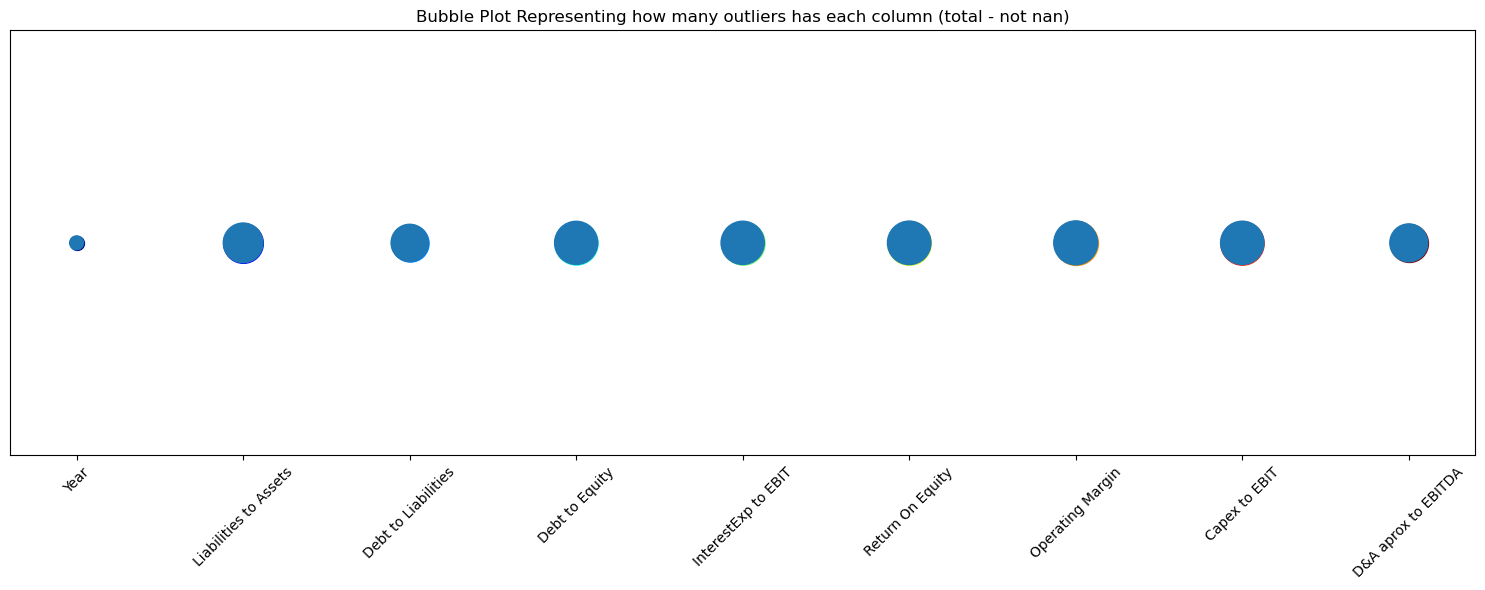

time: 390 ms (started: 2023-09-12 17:12:43 +02:00)


In [65]:
from sklearn.preprocessing import MinMaxScaler

# Call
Visual_Corporate.outliers_df_outliers_presence(df_outlier, exclude_columns=[])

# Setting custom outliers threshold based on previous analysis
1. Consider % of average outliers found by "auto" setting and 
2. Check nan % in dataframe
3. Reset threshold if needs

In [436]:
# NaN values sum
to_start_col = rt_y1.columns.get_loc('Year')
rt_y1.iloc[:, to_start_col+1:].isna().sum()/len(rt_y1)

Indices
Liabilities to Assets       0.01
Debt to Liabilities         0.11
Debt to Equity              0.11
InterestExp to EBIT         0.12
Return On Equity            0.01
Total_Shareholders_Equity   0.01
Operating Margin            0.03
Capex to EBIT               0.20
D&A aprox to EBITDA         0.06
dtype: float64

time: 16 ms (started: 2023-09-08 18:19:56 +02:00)


In [67]:
df_isofor_outliers1 = Visual_Corporate.isolation_forest(rt_y1, 
                     exclude_columns='Total_Shareholders_Equity', 
                     group_column=None, 
                     replace_nan_with_zero=True, 
                     replace_values_with_zero=None, 
                     threshold=0.03) # reset with custom threshold

time: 2.19 s (started: 2023-09-12 17:17:29 +02:00)


In [70]:
# data modelling (column and columns + '_outlier')
# df_iso_for1 = Visual_Corporate.iso_for_alternate_columns(df_isofor_outliers1, exclude_columns=['Total_Shareholders_Equity'])

time: 0 ns (started: 2023-09-12 17:17:50 +02:00)


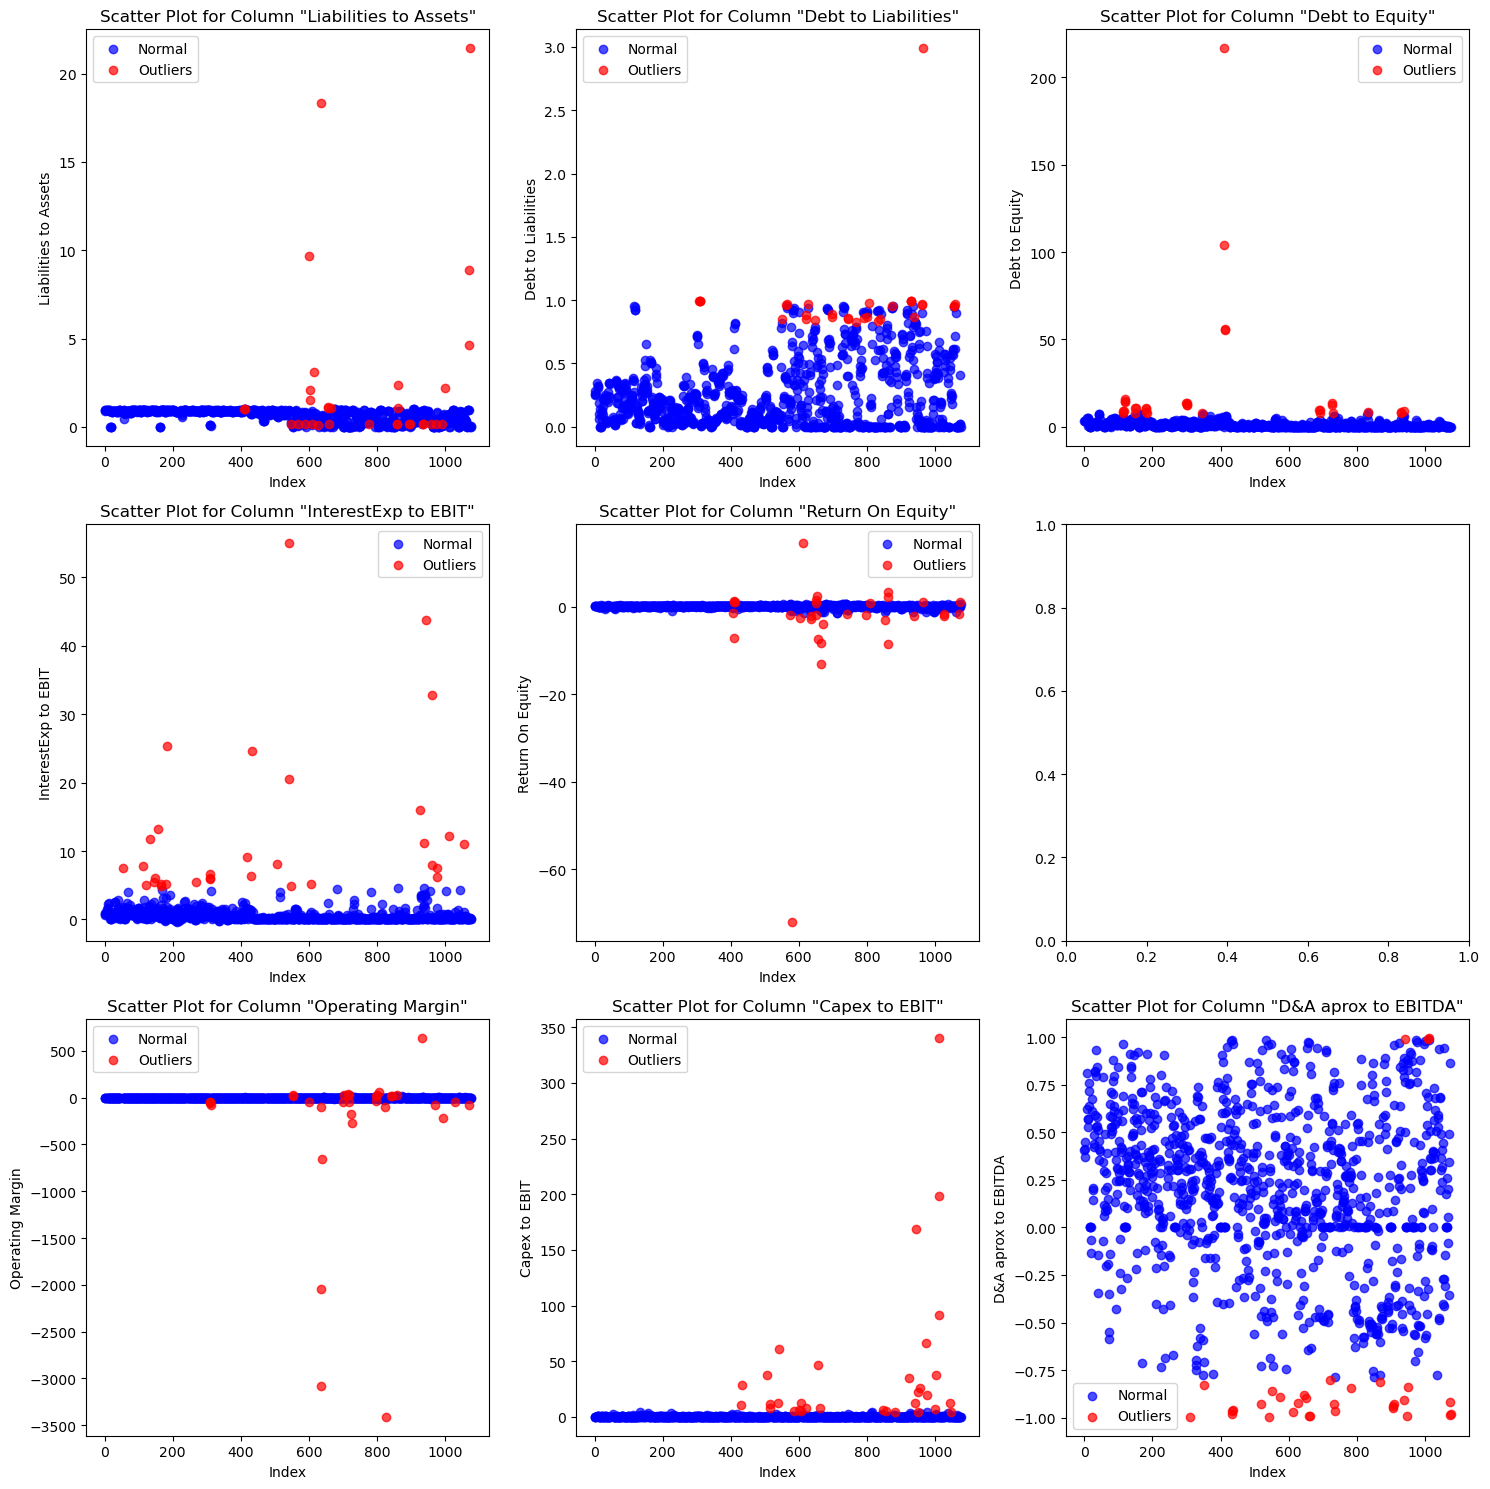

time: 2.7 s (started: 2023-09-12 17:18:36 +02:00)


In [72]:
# See difference from previous IsoFor settings by "auto"
Visual_Corporate.plot_outliers_scatter(df_isofor_outliers1, exclude_columns=['Year'], plots_per_row=3) # call: df_isofor_outliers1 (not the styled)

In [73]:
# Leave just values and replace others with nan
df_outlier1 = Visual_Corporate.outliers_df_iso_for(df_iso_for1, exclude_columns=['Total_Shareholders_Equity'])

time: 0 ns (started: 2023-09-12 17:18:48 +02:00)


### Box Plot: check without outliers found by last settings

Outliers or No Outliers: No Outliers


C:\Users\utente\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\utente\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\utente\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\utente\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will

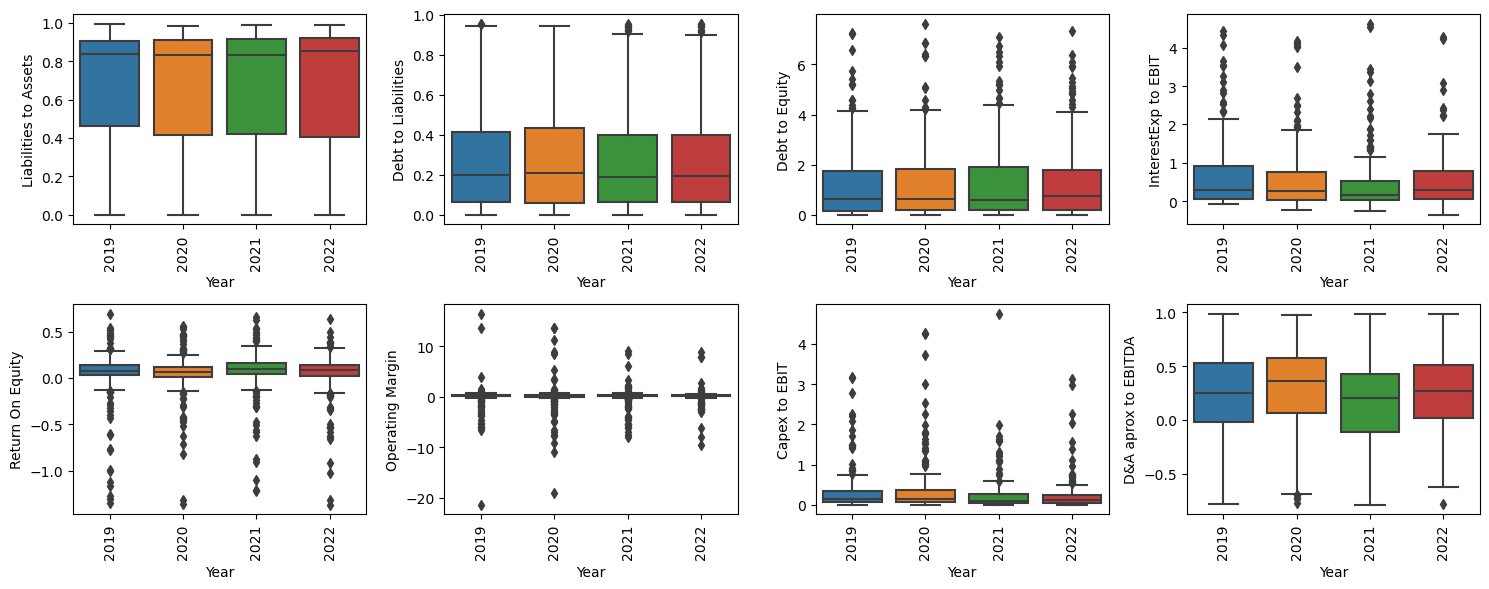

time: 7.28 s (started: 2023-09-12 17:19:13 +02:00)


In [74]:
# NOTE, make sure that:
# - 'df_outlier' only contain outliers
# - select df normalized with mean distance by each country

import math

# Select dataframe which include: Outliers or No Outliers
Visual_Corporate.Boxplot_DataDistribution('Year', rt_y1, df_outlier1, exclude_columns=['Total_Shareholders_Equity'])

## Replace outliers with missing values (NaN)

In [86]:
# make copy of dataframe
rt_y2 = rt_y1.copy()

time: 0 ns (started: 2023-09-12 17:28:24 +02:00)


In [87]:
# threshold setted 0.03 (it will sum up to nan already avaialble on dataset you will pass)

# dataframe passed
to_start_col = rt_y2.columns.get_loc('Year')
rt_y2.iloc[:, to_start_col+1:].isna().sum()/len(rt_y2)

Liabilities to Assets       0.01
Debt to Liabilities         0.11
Debt to Equity              0.11
InterestExp to EBIT         0.12
Return On Equity            0.01
Total_Shareholders_Equity   0.01
Operating Margin            0.03
Capex to EBIT               0.20
D&A aprox to EBITDA         0.06
dtype: float64

time: 0 ns (started: 2023-09-12 17:28:24 +02:00)


In [88]:
def replace_values_with_nan(main_df, outliers_df, exclude_columns=[], include_category=False):

    # Get 'category' column list
    category_columns = main_df.select_dtypes(include=['category']).columns.tolist()
    
    if not include_category:
        exclude_columns = list(set(exclude_columns + category_columns))
    
    # Get the list of numeric columns
    numeric_columns = main_df.select_dtypes(include=[np.number]).columns.tolist()

    for col in numeric_columns:
        if col not in exclude_columns:
            # Convert column to data type float64
            main_df[col] = main_df[col].astype('float64')
            main_df[col] = main_df[col].where(outliers_df[col].isna(), np.nan)
    
    return main_df

rt_y2 = replace_values_with_nan(rt_y2, df_outlier1, exclude_columns=['Total_Shareholders_Equity'], include_category=False)

time: 31 ms (started: 2023-09-12 17:28:25 +02:00)


In [89]:
# With outliers replaced with nan
to_start_col = rt_y2.columns.get_loc('Year')
rt_y2.iloc[:, to_start_col+1:].isna().sum()/len(rt_y2)

Liabilities to Assets       0.04
Debt to Liabilities         0.14
Debt to Equity              0.15
InterestExp to EBIT         0.15
Return On Equity            0.04
Total_Shareholders_Equity   0.01
Operating Margin            0.06
Capex to EBIT               0.23
D&A aprox to EBITDA         0.09
dtype: float64

time: 0 ns (started: 2023-09-12 17:28:26 +02:00)


## Check missing values (NaN)

In [90]:
import numpy as np
import pandas as pd
from IPython.display import display

def analyze_nan_values(df, column_filter=None, threshold=0.3): # custom threshold to check is some col is over 
    
    # Step a)
    print('ddc meaning: data, columns, countries\n')
    print('a): Are NaN over specified percentage of total data?')
    total_values = [df.select_dtypes(include=[np.number]).size]
    total_nan_values = [df.isna().sum().sum()]
    percent_nan_values = [total_nan_values[0] / total_values[0] * 100]
    threshold_over = ['Yes' if total_nan_values[0] / total_values[0] > threshold else 'No']
    df_a = pd.DataFrame({'Total values': total_values, 'Total NaN values': total_nan_values, '% NaN values': [f'{x:.0f}%' for x in percent_nan_values], 'Threshold over': threshold_over})
    df_data = display(df_a)

    # Step b)
    print('\nb) Are NaN over specified percentage in some columns?')
    if column_filter:
        numeric_columns = [column_filter]
    else:
        numeric_columns = df.select_dtypes(include=[np.number]).columns

    col_names = []
    total_values_b = []
    total_nan_values_b = []
    percent_nan_values_b = []
    threshold_over_b = []
    for col in numeric_columns:
        col_names.append(col)
        total_values_col = df[col].size
        total_values_b.append(total_values_col)
        nan_values = df[col].isna().sum()
        total_nan_values_b.append(nan_values)
        percent_nan_values_b.append(nan_values / total_values_col * 100)
        threshold_over_b.append('Yes' if nan_values / total_values_col > threshold else 'No')
    
    df_b = pd.DataFrame({'Column name': col_names, 'Total values': total_values_b, 'Total NaN values': total_nan_values_b, '% NaN values': [f'{x:.0f}%' for x in percent_nan_values_b], 'Threshold over': threshold_over_b})
    df_columns = display(df_b)

# Use function:
analyze_nan_values(rt_y2, column_filter=None, threshold=0.3)

ddc meaning: data, columns, countries

a): Are NaN over specified percentage of total data?


,Total values,Total NaN values,% NaN values,Threshold over
0,10460,941,9%,No



b) Are NaN over specified percentage in some columns?


,Column name,Total values,Total NaN values,% NaN values,Threshold over
0,Year,1046,0,0%,No
1,Liabilities to Assets,1046,45,4%,No
2,Debt to Liabilities,1046,142,14%,No
3,Debt to Equity,1046,152,15%,No
4,InterestExp to EBIT,1046,153,15%,No
5,Return On Equity,1046,41,4%,No
6,Total_Shareholders_Equity,1046,9,1%,No
7,Operating Margin,1046,62,6%,No
8,Capex to EBIT,1046,243,23%,No
9,D&A aprox to EBITDA,1046,94,9%,No


time: 31 ms (started: 2023-09-12 17:28:28 +02:00)


## Filter dataframe

In [91]:
# rt_y copied
rt_y3 = rt_y2.copy()

time: 16 ms (started: 2023-09-12 17:28:31 +02:00)


**Define columns to keep**

In [92]:
# Check potentially subgroups which have enough to predict 
rt_y3['Industry'].value_counts()

Industry
Investing/Securities    520
Banking/Credit          418
Insurance               108
Name: count, dtype: int64

time: 15 ms (started: 2023-09-12 17:28:32 +02:00)


In [93]:
def filter_columns(df, keep_columns, start_column):
    # Create a list of columns to keep based on the specified start point
    columns_from_start = df.columns[df.columns.get_loc(start_column):].tolist()
    
    # We merge the two column lists
    final_columns = keep_columns + columns_from_start
    
    # Filter the DataFrame to keep only the desired columns
    return df[final_columns]

time: 0 ns (started: 2023-09-12 17:28:33 +02:00)


In [94]:
rt_y3 = filter_columns(rt_y3, ['Industry', 'Country'], 'Year')
rt_y3 = rt_y3.sort_values(by='Year', ascending=True)

time: 0 ns (started: 2023-09-12 17:28:34 +02:00)


In [95]:
rt_y3.head()

,Industry,Country,Year,Liabilities to Assets,Debt to Liabilities,Debt to Equity,InterestExp to EBIT,Return On Equity,Total_Shareholders_Equity,Operating Margin,Capex to EBIT,D&A aprox to EBITDA
567,Investing/Securities,France,2019.00,0.04,0.35,0.02,0.00,0.13,1.00,0.49,NaN,0.09
78,Banking/Credit,Italy,2019.00,0.93,0.32,4.13,0.59,0.07,1.00,0.17,0.20,0.49
873,Investing/Securities,Sweden,2019.00,0.04,0.94,0.04,0.00,0.27,1.00,1.00,NaN,-0.46
426,Banking/Credit,Spain,2019.00,0.85,0.04,0.24,1.24,0.49,1.00,0.25,0.08,-0.40
881,Investing/Securities,Sweden,2019.00,0.47,0.60,0.52,1.15,0.01,1.00,0.01,1.41,0.86


time: 0 ns (started: 2023-09-12 17:28:34 +02:00)


## Skewness
*check data distribution*

In [97]:
def skewness_dataframe(df, exclude_columns=[]):
    df_copy = df.copy()
    selected_columns = df.select_dtypes(include=[np.number]).columns.tolist()  # Otteniamo una lista di colonne numeriche
    
    # Rimuovi le colonne da escludere dalla lista delle colonne selezionate
    for exc_col in exclude_columns:
        if exc_col in selected_columns:
            selected_columns.remove(exc_col)
            
    for col in selected_columns:
        klib.dist_plot(df_copy[col])

time: 0 ns (started: 2023-09-12 17:28:44 +02:00)


In [361]:
# skewness_dataframe(rt_y3)

time: 0 ns (started: 2023-09-08 17:57:19 +02:00)


## Encoding dataframe
- Industry: One-Hot Encoding
- Country: Label encodig (test because it can influence the predictions)
- Year: Ordinal encoding

### Read country list

**Before proceed with encoding and columns trasform read "aggregated_countries" dataframe (by GDrive or local path)**.   This table contains table with countries score base on their similarieties, gotten by macroeconomic part (proccess not public yet)

In [75]:
def read_gdrive_to_df(file_id):
    """
    Read an Excel file from Google Drive using its file ID and return a DataFrame.
    """
    base_url = f'https://drive.google.com/file/d/{file_id}/view?usp=sharing'
    download_url = 'https://drive.google.com/uc?id=' + base_url.split('/')[-2]
    return pd.read_excel(download_url, index_col=0)

# File IDs
aggregated_countries_link = '1t-lU_WfxN2ddB-yLKq2em3A6HGiQcuCj' 

# Read files using the function
aggregated_countries = read_gdrive_to_df(aggregated_countries_link) # mean distance from year for each country

time: 3.05 s (started: 2023-09-12 17:22:39 +02:00)


In [83]:
aggregated_countries.sort_values(by='TotPtsQle', ascending=False)

,TotPtsQle,Number,Countries
16,29,1,Germany
15,26,1,Belgium
14,25,1,Netherlands
13,23,1,Switzerland
12,19,3,"Austria, Denmark, Luxembourg"
11,18,1,Malta
10,17,2,"Cyprus, Sweden"
9,16,4,"Greece, Ireland, Italy, Portugal"
8,15,2,"Czechia, Poland"
7,14,4,"France, Hungary, Norway, Spain"


time: 0 ns (started: 2023-09-12 17:28:02 +02:00)


### Encoding steps

In [98]:
# 1.--- One Hot Encoding per 'industry_name'
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(df, column_name, prefix=None):

    if prefix is None:
        prefix = column_name

    df = pd.concat([df, pd.get_dummies(df[column_name], prefix=prefix)], axis=1)
    df.drop(column_name, axis=1, inplace=True)
    
    # List of one-hot columns created
    one_hot_columns = [col for col in df.columns if prefix in col and col != column_name]
    
    # Replace true and false with 0 and 1
    for col in one_hot_columns:
        df[col] = df[col].astype(int)
    
    return df

rt_y3 = one_hot_encode(rt_y3, 'Industry', 'Industry')

time: 16 ms (started: 2023-09-12 17:28:50 +02:00)


In [99]:
# 2.--- Countries: inizialize disct to map (!! this approach can be change leaving just countries instead of values)
country_mapping = {}

#  Populating of the mapping dictionary
for index, row in aggregated_countries.iterrows():
    countries = row['Countries'].split(", ")
    for country in countries:
        country_mapping[country] = row['TotPtsQle']

# Map values in the rt_y1 'Country' column using the dictionary
rt_y3['Country'] = rt_y3['Country'].map(country_mapping)

time: 0 ns (started: 2023-09-12 17:28:52 +02:00)


In [100]:
# 3.--- Ordinal Encoding per 'Year'
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# If they are not, you can specify the order with the 'categories' parameter of the OrdinalEncoder
def ordinal_encode(df, column_name):

    oe = OrdinalEncoder(categories=[sorted(df[column_name].unique())])
    df[column_name] = oe.fit_transform(df[[column_name]]).astype(int)
    
    return df, oe

rt_y3, oe = ordinal_encode(rt_y3, 'Year')

time: 16 ms (started: 2023-09-12 17:28:53 +02:00)


In [101]:
# --- Order columns (one hot col first)
# List cols one hot
one_hot_columns = [col for col in rt_y3.columns if "Industry_" in col]

# Column order: first one-hot columns, then the others
new_column_order = one_hot_columns + [col for col in rt_y3.columns if col not in one_hot_columns]

# Rearrange the DataFrame columns in the new order
rt_y3 = rt_y3[new_column_order]

time: 15 ms (started: 2023-09-12 17:28:53 +02:00)


In [102]:
# Check df encoded
rt_y3.head()

,Industry_Banking/Credit,Industry_Insurance,Industry_Investing/Securities,Country,Year,Liabilities to Assets,Debt to Liabilities,Debt to Equity,InterestExp to EBIT,Return On Equity,Total_Shareholders_Equity,Operating Margin,Capex to EBIT,D&A aprox to EBITDA
567,0,0,1,14,0,0.04,0.35,0.02,0.00,0.13,1.00,0.49,NaN,0.09
78,1,0,0,16,0,0.93,0.32,4.13,0.59,0.07,1.00,0.17,0.20,0.49
873,0,0,1,17,0,0.04,0.94,0.04,0.00,0.27,1.00,1.00,NaN,-0.46
426,1,0,0,14,0,0.85,0.04,0.24,1.24,0.49,1.00,0.25,0.08,-0.40
881,0,0,1,17,0,0.47,0.60,0.52,1.15,0.01,1.00,0.01,1.41,0.86


time: 16 ms (started: 2023-09-12 17:28:55 +02:00)


# Imputation models testing
(data imputation models used are available on the repository GitHub)
--> [link to repository](https://github.com/filippoesfea/dataimputation)

In [103]:
# copy df
rt_y4 = rt_y3.copy()

time: 0 ns (started: 2023-09-12 17:28:58 +02:00)


## Test MICE model

In [767]:
# Install libraries need
# pip install miceforest
# pip install miceforest --upgrade
# pip install git+https://github.com/AnotherSamWilson/miceforest.git # (if miceforest previous install does not work)
# pip install dask --upgrade
# pip install lightgbm --upgrade

time: 0 ns (started: 2023-09-02 23:00:01 +02:00)


In [104]:
# Miceforest (MICE)
import miceforest as mf
from miceforest import ImputationKernel
from sklearn.metrics import mean_squared_error

time: 0 ns (started: 2023-09-12 17:29:03 +02:00)


In [11]:
# test one: made by all data
Visual_Corporate.mice_imputation_test(rt_y4, col_to_test = 'Return On Equity',
                                      cols_to_category=['Industry_Banking/Credit', 'Industry_Insurance',
                                      'Industry_Investing/Securities', 'Country', 'Year'])

In [928]:
# Plot compare the distribution by data and data with imputation
# kds.plot_imputed_distributions(wspace=0.3,hspace=0.5)

time: 16 ms (started: 2023-09-03 13:07:05 +02:00)


## Test skelearn models

In [514]:
#- sklearn imputation libraries
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge

time: 46 ms (started: 2023-09-08 18:39:34 +02:00)


**BayesianRidge**

In [106]:
# Visual_Corporate.iterative_imputation_sklearn(rt_y4, estimator_choice='BayesianRidge', col_to_test = 'Return On Equity', grouping_col = None)

time: 0 ns (started: 2023-09-12 17:35:01 +02:00)


In [120]:
# Read .py doc global variable
from Visual_Corporate import iterative_imputation_sklearn, imputed_df, comparison_df, percentage_error_sklearn, rmse_sklearn

time: 0 ns (started: 2023-09-12 17:40:27 +02:00)


In [121]:
# Global variables called
percentage_error_sklearn_Bayesian = percentage_error_sklearn
rmse_sklearn_Bayesian = rmse_sklearn

time: 0 ns (started: 2023-09-12 17:40:47 +02:00)


**LinearRegression (before running it, run once again the model)**

In [126]:
iterative_imputation_sklearn(rt_y1, estimator_choice='LinearRegression', col_to_test = 'Return On Equity', grouping_col = None)

time: 0 ns (started: 2023-09-12 19:35:25 +02:00)


In [521]:
# Name variable
percentage_error_sklearn_Linear = percentage_error_sklearn
rmse_sklearn_Linear = rmse_sklearn

time: 0 ns (started: 2023-09-08 18:40:49 +02:00)


## Plot models results

In [522]:
# Print models RMSE percentage_error (min,max) and RMSE

# --- result imputation model tested
print('All imputation model tested results\n')
print('MICE')
print(f'RMSE percentage_error (min,max): {percentage_error_mice:.2f}')
print(f'RMSE: {rmse_mice:.2f}')
print('='*15)

print('BayesianRidge')
print(f"RMSE percentage_error (min,max): {percentage_error_sklearn_Bayesian:.2f}")
print(f'RMSE: {rmse_sklearn_Bayesian:.2f}')
print('='*15)

print('LinearRegression')
print(f"RMSE percentage_error (min,max): {percentage_error_sklearn_Linear:.2f}")
print(f'RMSE: {rmse_sklearn_Linear:.2f}')

print('\nNOTE: random seed is not implemented. So, outputs can change running from scratch the model. Make decision considering also some random tests.')

All imputation model tested results

MICE
RMSE percentage_error (min,max): 10.24
RMSE: 0.21
BayesianRidge
RMSE percentage_error (min,max): 8.45
RMSE: 0.17
LinearRegression
RMSE percentage_error (min,max): 0.43
RMSE: 0.37

NOTE: random seed is not implemented. So, outputs can change running from scratch the model. Make decision considering also some random tests.
time: 16 ms (started: 2023-09-08 18:40:51 +02:00)


## Impute missing values with best performed method tested

**Model selected**: BayesianRidge

In [523]:
# Copy df
rt_y4_imputed = rt_y4.copy()

time: 0 ns (started: 2023-09-08 18:41:51 +02:00)


In [524]:
# Before imputation
rt_y4_imputed.isna().sum().sum()

941

time: 0 ns (started: 2023-09-08 18:41:52 +02:00)


In [124]:
from Visual_Corporate import iterative_imputation_sklearn_all_df, imputed_df, comparison_df, percentage_error_sklearn, rmse_sklearn, imputed_coordinates, coordinates_df, imputed_values_list, styles

time: 0 ns (started: 2023-09-12 17:45:57 +02:00)


In [10]:
# BayesianRidge
Visual_Corporate.iterative_imputation_sklearn_all_df(rt_y4_imputed, estimator_choice='BayesianRidge', col_to_test = 'Return On Equity', grouping_col = None, highlight_imputed=True)

In [611]:
# Dataframe explained for each column index where nan has been replaces
# coordinates_df.sort_values(by=['Liabilities to Assets'], ascending=True)

time: 0 ns (started: 2023-09-08 20:13:31 +02:00)


In [529]:
# Sum tot nan after imputation
rt_y4_imputed.isna().sum().sum()

0

time: 0 ns (started: 2023-09-08 18:44:25 +02:00)


## Skewness

In [1132]:
# rt_y1_imputed.columns

time: 0 ns (started: 2023-09-03 15:57:53 +02:00)


In [1140]:
# Check the skewness
# skewness_dataframe(rt_y1_imputed, exclude_columns=['industry_name_Banking/Credit', 'industry_name_Insurance',
#        'industry_name_Investing/Securities', 'Country', 'Year'])

time: 0 ns (started: 2023-09-03 16:05:54 +02:00)


## Decoding

In [662]:
# Copy imputed df
rt_y1_pred = rt_y4_imputed.copy()

time: 15 ms (started: 2023-09-08 22:26:15 +02:00)


In [663]:
# 1. --- Decoding of industry columns encoded previously

def get_industry_name(row):
    for col in one_hot_columns:
        if row[col] == 1:
            return col.replace('Industry_', '')
    return None

# Apply the function to DataFrame to create the new 'industry_name' column
rt_y1_pred['Industry'] = rt_y1_pred.apply(get_industry_name, axis=1)

# Now remove the one-hot columns
rt_y1_pred.drop(one_hot_columns, axis=1, inplace=True)

time: 15 ms (started: 2023-09-08 22:26:15 +02:00)


In [664]:
# 2. --- Set industry col in first position
cols = [col for col in rt_y1_pred.columns if col != 'Industry']

# Place 'industry_name' as first column
cols = ['Industry'] + cols

# Reordina il DataFrame
rt_y1_pred = rt_y1_pred[cols]

time: 0 ns (started: 2023-09-08 22:26:16 +02:00)


In [665]:
# 3. --- Decode 'Year' col and set it ad datatime
rt_y1_pred['Year'] = oe.inverse_transform(rt_y1_pred[['Year']])[:, 0]

time: 16 ms (started: 2023-09-08 22:26:16 +02:00)


In [666]:
# 4. ---  Sort values
rt_y1_pred = rt_y1_pred.sort_values(by='Year', ascending=True)

# Trasform to datatime adding month and year (are just rapresentative)
rt_y1_pred['Year'] = pd.to_datetime(rt_y1_pred['Year'].astype(str) + '-12-31')

time: 0 ns (started: 2023-09-08 22:26:19 +02:00)


In [669]:
# 5. ---  Replace countries values with name
rt_y1_pred['Country'] = rt_y3.loc[rt_y1_pred.index, 'Country']

time: 16 ms (started: 2023-09-08 22:31:00 +02:00)


### Imputed Dataframe

In [17]:
rt_y1_pred

,Industry,Country,Year,Liabilities to Assets,Debt to Liabilities,Debt to Equity,InterestExp to EBIT,Return On Equity,Total_Shareholders_Equity,Operating Margin,Capex to EBIT,D&A aprox to EBITDA
567,Investing/Securities,France,2019-12-31,0.044072,0.347287,0.016011,0.001907,0.131094,1.0,0.485101,0.299175,0.093327
623,Investing/Securities,Spain,2019-12-31,0.353761,0.155999,0.085396,0.004596,0.189078,1.0,0.253839,0.044677,0.458537
386,Banking/Credit,Germany,2019-12-31,0.880365,0.171946,1.265302,0.586420,0.108497,1.0,0.301115,0.206190,0.283978
1001,Investing/Securities,Hungary,2019-12-31,0.515411,0.387706,0.448869,0.428851,-0.004934,1.0,-0.056523,0.206625,-0.581303
374,Banking/Credit,Norway,2019-12-31,0.825243,0.423529,2.000000,0.509080,0.129944,1.0,0.576976,0.010945,-0.053330
...,...,...,...,...,...,...,...,...,...,...,...,...
37,Banking/Credit,Austria,2022-12-31,0.875000,0.028076,0.197508,0.333929,0.034437,1.0,0.192837,0.141071,0.533333
1058,Investing/Securities,Germany,2022-12-31,0.462141,0.451929,0.832524,0.165343,0.141403,1.0,1.017830,0.034799,-0.273828
433,Banking/Credit,Spain,2022-12-31,0.787131,0.216289,0.799779,0.831286,-0.081260,1.0,-0.002759,0.544036,0.986436
537,Insurance,Norway,2022-12-31,0.796209,0.092262,0.360465,-0.205887,0.245730,1.0,0.167987,0.041274,-0.493632


<!--  -->